In [155]:
import shutil
from tqdm import tqdm
import time
import gc
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np

def load_data(datasets=None):

    ## PRELOAD DATASETS
    dataset_pile = load_dataset("timaeus/pile_subsets_mini", split="train")
    dataset_pile = dataset_pile.add_column(
        "idx", list(range(len(dataset_pile))))
    dataset_pile = filter_subsets(
        dataset_pile, include=datasets, exclude=["dm_mathematics"])

    dataset_dm_math = load_dataset("timaeus/dm_mathematics_mini", split="train")

    return dict(
        dataset_pile=dataset_pile,
        dataset_dm_math=dataset_dm_math,
    )

data = load_data()

tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-6.9b")


In [156]:
def find_induction_patterns(input_ids, pattern_filter=None):
    """
    Find indices of candidate induction patterns.
    
    Args:
        input_ids: Tensor of token IDs
        pattern_filter: Optional function that takes (token_a, token_b, token_c=None) and returns
                       a boolean indicating whether to include the pattern. token_c is provided
                       only for suppression patterns (when token_a is followed by something other than token_b).
        
    Returns:
        Dictionary mapping (token_a, token_b) pairs to lists of indices where token_a appears
        and is followed by either token_b (induction) or something else (suppression)
    """
    patterns = {}
    
    # Convert to numpy for easier processing if it's a tensor
    if isinstance(input_ids, torch.Tensor):
        input_ids = input_ids.cpu().numpy()
        cast = int
    elif isinstance(input_ids, np.ndarray):
        cast = int
    else: 
        cast = lambda x: x
    
    # Iterate through the sequence to find token pairs
    for i in range(len(input_ids) - 1):
        token_a = input_ids[i]
        token_b = input_ids[i + 1]
        
        # Create a key for this token pair
        pair = (cast(token_a), cast(token_b))
        
        # Initialize entry if this is the first time seeing this pair
        if pair not in patterns:
            patterns[pair] = {
                'induction': [],  # indices where token_a is followed by token_b again
                'suppression': []  # indices where token_a is followed by something else
            }
        
        # Find all subsequent occurrences of token_a
        for j in range(i + 2, len(input_ids) - 1):
            if input_ids[j] == token_a:
                # Check if it's followed by token_b (induction) or something else (suppression)
                if input_ids[j + 1] == token_b:
                    # Apply filter if provided
                    if pattern_filter is None or pattern_filter(cast(token_a), cast(token_b)):
                        patterns[pair]['induction'].append(j + 1)
                else:
                    # Apply filter if provided
                    token_c = input_ids[j + 1]
                    if pattern_filter is None or pattern_filter(cast(token_a), cast(token_b), cast(token_c)):
                        patterns[pair]['suppression'].append(j + 1)
    
    return patterns


def render_induction_patterns_html(input_ids, tokenizer, patterns=None):
    """
    Render induction patterns as HTML with color highlighting.
    
    Args:
        input_ids: Tensor or array of token IDs
        tokenizer: The tokenizer to decode tokens
        patterns: Optional pre-computed patterns dictionary
        
    Returns:
        HTML string with highlighted induction patterns
    """
    if patterns is None:
        patterns = find_induction_patterns(input_ids)
    
    # Convert to numpy if tensor
    if isinstance(input_ids, torch.Tensor):
        input_ids = input_ids.cpu().numpy()
    
    # Create a mapping of indices to their highlighting status
    # 0: no highlight, 1: induction (blue), 2: suppression (red), 3: both (green)
    highlight_map = [0] * len(input_ids)
    
    # Track which indices are part of induction and suppression patterns
    induction_indices = set()
    suppression_indices = set()
    
    # Fill the highlight map based on patterns
    for (token_a, token_b), indices in patterns.items():
        # Add indices to the respective sets
        induction_indices.update(indices['induction'])
        suppression_indices.update(indices['suppression'])
    
    # Find indices that appear in both sets
    both_indices = induction_indices.intersection(suppression_indices)
    
    # Mark tokens that appear in both patterns as green (3)
    for idx in both_indices:
        highlight_map[idx] = 3
    
    # Mark remaining induction tokens as blue (1)
    for idx in induction_indices - both_indices:
        highlight_map[idx] = 1
    
    # Mark remaining suppression tokens as red (2)
    for idx in suppression_indices - both_indices:
        highlight_map[idx] = 2
    
    # Generate HTML with highlighting
    html_parts = ['<div style="font-family: monospace; white-space: pre-wrap;">']
    
    for i, token_id in enumerate(input_ids):
        # Decode the token
        if tokenizer is not None: 
            token_text = tokenizer.decode([token_id])
        else: 
            token_text = str(token_id)
        
        # Apply highlighting based on the map
        if highlight_map[i] == 1:  # Induction only (blue)
            html_parts.append(f'<span style="background-color: rgba(0, 0, 255, 0.3);">{token_text}</span>|')
        elif highlight_map[i] == 2:  # Suppression only (red)
            html_parts.append(f'<span style="background-color: rgba(255, 0, 0, 0.3);">{token_text}</span>|')
        elif highlight_map[i] == 3:  # Both induction and suppression (green)
            html_parts.append(f'<span style="background-color: rgba(0, 128, 0, 0.3);">{token_text}</span>|')
        else:  # No highlight
            html_parts.append(f'{token_text}|')
    
    html_parts.append('</div>')
    
    return ''.join(html_parts)


# Example usage in a Jupyter notebook:
from IPython.display import HTML


def display_induction_patterns(text, tokenizer=None, pattern_filter=None):
    """
    Display induction patterns in a text with color highlighting.
    
    Args:
        text: Input text to analyze
        tokenizer: The tokenizer
        model: Optional model for calculating scores
        
    Returns:
        HTML display object and optionally scores
    """
    # Tokenize the input
    if tokenizer is not None: 
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs.input_ids[0]
    else: 
        input_ids = text
    
    # Find patterns
    patterns = find_induction_patterns(input_ids, pattern_filter)
     
    # Track which indices are part of induction and suppression patterns
    induction_indices = set()
    suppression_indices = set()
    
    # Fill the sets based on patterns
    for (token_a, token_b), indices in patterns.items():
        # Add indices to the respective sets
        induction_indices.update(indices['induction'])
        suppression_indices.update(indices['suppression'])
    
    # Find indices that appear in both sets
    both_indices = induction_indices.intersection(suppression_indices)
    
    # Get the counts
    induction_only_count = len(induction_indices - both_indices)
    suppression_only_count = len(suppression_indices - both_indices)
    both_count = len(both_indices)
    total_highlighted = induction_only_count + suppression_only_count + both_count
    
    # Render HTML
    html_output = render_induction_patterns_html(input_ids, tokenizer, patterns)
    
    # Add summary statistics
    summary_html = f"""
    <div style="margin-top: 10px; font-family: sans-serif;">
        <h4>Induction Pattern Summary:</h4>
        <ul>
            <li><span style="background-color: rgba(0, 0, 255, 0.3); padding: 2px 5px;">Induction only: {induction_only_count} tokens</span></li>
            <li><span style="background-color: rgba(255, 0, 0, 0.3); padding: 2px 5px;">Suppression only: {suppression_only_count} tokens</span></li>
            <li><span style="background-color: rgba(0, 128, 0, 0.3); padding: 2px 5px;">Both: {both_count} tokens</span></li>
            <li>Total highlighted: {total_highlighted} tokens</li>
            <li>Total tokens: {len(input_ids)}</li>
        </ul>
    </div>
    """
    
    # Combine the HTML
    combined_html = html_output + summary_html
    
    # Calculate scores if model is provided
    scores = None
    
    # Display HTML
    display_html = HTML(combined_html)
    
    if scores:
        return display_html, scores
    return display_html


# Example with clear induction patterns
text1 = "The capital of France is Paris. The capital of Germany is Berlin. The capital of Spain is Madrid. The capital of France is Paris. The capital of Germany is Berlin."

def filter_capitalized(token_a, token_b, token_c=None):
    return any(c.isupper() for c in tokenizer.decode([token_b]))

# Basic visualization with better example
html_display = display_induction_patterns(text1, tokenizer, pattern_filter=filter_capitalized)
html_display

In [157]:
# Example with both induction and suppression
text2 = "The quick brown fox jumps over the lazy dog. The quick brown fox runs away. The lazy dog sleeps. The quick brown fox jumps over the fence."

# Basic visualization with better example
html_display = display_induction_patterns(text2, tokenizer)
html_display

In [158]:
# Example with repetitive structure
text3 = "Alice likes to eat apples. Bob likes to eat bananas. Charlie likes to eat cherries. Alice likes to eat oranges. Bob likes to eat apples."
html_display = display_induction_patterns(text3, tokenizer)
html_display

In [159]:
text3 = "Alice likes to eat apples. Bob likes to eat bananas. Charlie likes to eat cherries. Alice likes to eat oranges. Bob likes to eat apples."
html_display = display_induction_patterns(text3, tokenizer)
html_display

In [160]:
import pickle
import pandas as pd

github_tokens = pickle.load(open("../../experimental/github_tokens.pkl", "rb"))
len(github_tokens), len(github_tokens[2]), github_tokens[2][:5]

FileNotFoundError: [Errno 2] No such file or directory: '../../experimental/github_tokens.pkl'

In [28]:
github_small_1_4b = pd.read_csv("../../experimental/1.4b_github_small.csv")
github_small_1_4b.head()

step  context_2_pos_0  context_2_pos_1  context_2_pos_2  context_2_pos_3  \
0     0             -0.0           10.625           11.010             11.1   
1     1             -0.0           10.625           11.010             11.1   
2     2             -0.0           10.625           11.016             11.1   

   context_2_pos_4  context_2_pos_5  context_2_pos_6  context_2_pos_7  \
0             10.1            10.50           11.270           11.016   
1             10.1            10.50           11.270           11.016   
2             10.1            10.48           11.266           11.016   

   context_2_pos_8  ...  context_6645_pos_502  context_6645_pos_503  \
0           11.766  ...                11.414                12.055   
1           11.766  ...                11.414                12.055   
2           11.734  ...                11.414                12.050   

   context_6645_pos_504  context_6645_pos_505  context_6645_pos_506  \
0                 10.11                 9.945                 11.23   
1                 10.11                 9.945                 11.23   
2                 10.11                 9.945                 11.19   

   context_6645_pos_507  context_6645_pos_508  context_6645_pos_509  \
0                 10.76                 11.23                10.945   
1                 10.76                 11.23                10.945   
2                 10.75                 11.23                10.945   

   context_6645_pos_510  context_6645_pos_511  
0                 11.24                 11.55  
1                 11.24                 11.55  
2                 11.21                 11.55  

[3 rows x 262145 columns]

In [ ]:
github_6_9b = pd.read_csv("../../experimental/6.9b_github.csv")
github_6_9b.head()

step  context_2_pos_0  context_2_pos_1  context_2_pos_2  context_2_pos_3  \
0     0             -0.0            11.13            11.78           11.240   
1     1             -0.0            11.13            11.78           11.240   
2     2             -0.0            11.13            11.78           11.234   
3     4             -0.0            11.10            11.78           11.140   
4     8             -0.0            11.00            11.82           10.560   

   context_2_pos_4  context_2_pos_5  context_2_pos_6  context_2_pos_7  \
0            10.10           10.020           13.050           12.766   
1            10.10           10.020           13.050           12.766   
2            10.10            9.980           13.050           12.766   
3            10.12            9.000           13.055           12.680   
4            10.44            2.512           13.340           12.390   

   context_2_pos_8  ...  context_6645_pos_502  context_6645_pos_503  \
0            11.21  ...                12.840                12.055   
1            11.21  ...                12.840                12.055   
2            11.16  ...                12.850                12.050   
3            10.09  ...                12.984                11.880   
4             2.91  ...                14.016                11.580   

   context_6645_pos_504  context_6645_pos_505  context_6645_pos_506  \
0                 12.03                10.270                9.8000   
1                 12.03                10.270                9.8000   
2                 12.03                10.270                9.7300   
3                 11.99                10.266                8.3600   
4                 12.14                10.760                0.4934   

   context_6645_pos_507  context_6645_pos_508  context_6645_pos_509  \
0                12.030                 13.01                14.690   
1                12.030                 13.01                14.690   
2                12.030                 13.00                14.680   
3                11.984                 12.84                14.520   
4                13.350                 12.26                13.734   

   context_6645_pos_510  context_6645_pos_511  
0                10.960                 12.01  
1                10.960                 12.01  
2                10.910                 12.01  
3                 9.875                 11.99  
4                 3.566                 12.22  

[5 rows x 262145 columns]

In [ ]:
def is_punctuation(token):
    return token.strip() and not token.strip().isalpha()

# Example filter functions
def filter_for_punctuation(token_a, token_b, token_c=None):
    """Only include patterns where token_a is a specific value"""
    return (not token_c and is_punctuation(token_b)) or (token_c and is_punctuation(token_c))

html_display = display_induction_patterns(github_tokens[2], pattern_filter=filter_for_punctuation)
html_display

In [83]:
def calculate_masked_losses(tokens, scores_df, context_column_prefix="context_2_pos_"):
    """
    Calculate masked losses for induction patterns in tokens.
    
    Args:
        tokens: List of tokens to analyze
        scores_df: DataFrame with loss scores
        context_column_prefix: Prefix for the column names containing losses
        
    Returns:
        Dictionary with different masked losses
    """
    # Find induction patterns in the tokens
    patterns = find_induction_patterns(tokens)
    
    # Track which indices are part of induction and suppression patterns
    induction_indices = set()
    suppression_indices = set()
    
    # Fill the sets based on patterns
    for (token_a, token_b), indices in patterns.items():
        # Add indices to the respective sets
        induction_indices.update(indices['induction'])
        suppression_indices.update(indices['suppression'])
    
    # Find indices that appear in both sets
    both_indices = induction_indices.intersection(suppression_indices)
    induction_only_indices = induction_indices - both_indices
    suppression_only_indices = suppression_indices - both_indices
    
    # Add 1 to all indices to get the position of token B or C (not token A)
    induction_only_indices_next = {idx for idx in induction_only_indices}
    suppression_only_indices_next = {idx  for idx in suppression_only_indices}
    both_indices_next = {idx for idx in both_indices}
    
    # Get all column names for the context
    context_columns = [col for col in scores_df.columns if col.startswith(context_column_prefix)]
    
    # Calculate masked losses
    results = {}
    
    # Full loss (average of all positions)
    full_loss = scores_df[context_columns].mean().mean()
    results['full_loss'] = full_loss
    
    # Masked losses for each category
    masked_losses = {}
    
    for col in context_columns:
        # Extract position from column name
        pos = int(col.split('_')[-1])
        
        # Check which category this position belongs to
        if pos in induction_only_indices_next:
            category = 'induction_only'
        elif pos in suppression_only_indices_next:
            category = 'suppression_only'
        elif pos in both_indices_next:
            category = 'both'
        else:
            category = 'none'
        
        # Add to the appropriate category
        if category not in masked_losses:
            masked_losses[category] = []
        
        masked_losses[category].extend(scores_df[col].tolist())
    
    # Calculate average loss for each category
    for category, losses in masked_losses.items():
        if losses:  # Only calculate if there are values
            results[f'{category}_loss'] = sum(losses) / len(losses)
        else:
            results[f'{category}_loss'] = float('nan')
    
    # Add counts
    results['induction_only_count'] = len(induction_only_indices_next)
    results['suppression_only_count'] = len(suppression_only_indices_next)
    results['both_count'] = len(both_indices_next)
    results['total_tokens'] = len(tokens)
    
    return results

In [143]:

import base64


def visualize_induction_analysis(analysis_results, tokenizer=None, pattern_filter=None, title=None):
    """
    Create visualizations for induction pattern analysis.
    
    Args:
        analysis_results: Results from compute_induction_analysis
        tokenizer: Optional tokenizer for decoding tokens
        
    Returns:
        HTML display object
    """
    tokens = analysis_results['tokens']
    patterns = analysis_results['patterns']
    checkpoint_results = analysis_results['checkpoint_results']
    trends_df = analysis_results['trends_df']
    
    # Display induction patterns
    html_display = display_induction_patterns(tokens, tokenizer, pattern_filter=pattern_filter)
    
    # Get the first checkpoint for summary statistics
    first_step = min(checkpoint_results.keys())
    first_result = checkpoint_results[first_step]
    
    # Create a summary of the token counts
    count_summary = f"""
    <div style="margin-top: 20px; font-family: sans-serif;">
        <h4>Token Counts:</h4>
        <ul>
            <li><span style="background-color: rgba(0, 0, 255, 0.3); padding: 2px 5px;">
                Induction only: {first_result['induction_only_count']} tokens</span></li>
            <li><span style="background-color: rgba(255, 0, 0, 0.3); padding: 2px 5px;">
                Suppression only: {first_result['suppression_only_count']} tokens</span></li>
            <li><span style="background-color: rgba(0, 128, 0, 0.3); padding: 2px 5px;">
                Both: {first_result['both_count']} tokens</span></li>
            <li>Total tokens: {first_result['total_tokens']}</li>
        </ul>
    </div>
    """
    
    # # Create a table of losses at different checkpoints
    # table_rows = []
    # table_rows.append("<tr><th>Step</th><th>Full Loss</th><th>Induction Only</th><th>Suppression Only</th><th>Both</th><th>None</th></tr>")
    
    # for step, results in sorted(checkpoint_results.items()):
    #     row = f"<tr><td>{step}</td><td>{results['full_loss']:.4f}</td>"
    #     row += f"<td>{results.get('induction_only_loss', float('nan')):.4f}</td>"
    #     row += f"<td>{results.get('suppression_only_loss', float('nan')):.4f}</td>"
    #     row += f"<td>{results.get('both_loss', float('nan')):.4f}</td>"
    #     row += f"<td>{results.get('none_loss', float('nan')):.4f}</td></tr>"
    #     table_rows.append(row)
    
    # table_html = f"""
    # <div style="margin-top: 20px; font-family: sans-serif;">
    #     <h4>Loss Values by Checkpoint:</h4>
    #     <table border="1" style="border-collapse: collapse; width: 100%;">
    #         {"".join(table_rows)}
    #     </table>
    # </div>
    # """
    table_html = ""
    
    # Plot the trends
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    # Left plot - log x scale only
    ax1.plot(trends_df['step'], trends_df['full_loss'], 'k-', label='Full Loss')
    ax1.plot(trends_df['step'], trends_df['induction_only_loss'], 'b-', label='Induction Only')
    ax1.plot(trends_df['step'], trends_df['suppression_only_loss'], 'r-', label='Suppression Only')
    ax1.plot(trends_df['step'], trends_df['both_loss'], 'g-', label='Both')
    ax1.plot(trends_df['step'], trends_df['none_loss'], 'y-', label='None')
    ax1.set_xscale('log')
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Trends (Log X Scale)')
    ax1.legend()
    ax1.grid(True)
    
    # Right plot - log x and log y scale
    ax2.plot(trends_df['step'], trends_df['full_loss'], 'k-', label='Full Loss')
    ax2.plot(trends_df['step'], trends_df['induction_only_loss'], 'b-', label='Induction Only')
    ax2.plot(trends_df['step'], trends_df['suppression_only_loss'], 'r-', label='Suppression Only')
    ax2.plot(trends_df['step'], trends_df['both_loss'], 'g-', label='Both')
    ax2.plot(trends_df['step'], trends_df['none_loss'], 'y-', label='None')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Loss (Log Scale)')
    ax2.set_title('Loss Trends (Log X & Y Scale)')
    ax2.legend()
    ax2.grid(True)

    if title:
        plt.suptitle(title)
    
    plt.tight_layout()
    
    buf = BytesIO()
    # plt.savefig(buf, format='png')
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode('utf-8')
    
    plot_html = f"""
    <div style="margin-top: 20px;">
        <h4>Loss Trends:</h4>
        <img src="data:image/png;base64,{img_str}" alt="Loss Trends">
    </div>
    """
    
    # Combine all HTML elements
    combined_html = HTML(html_display._repr_html_() + count_summary + table_html + plot_html)
    
    return combined_html


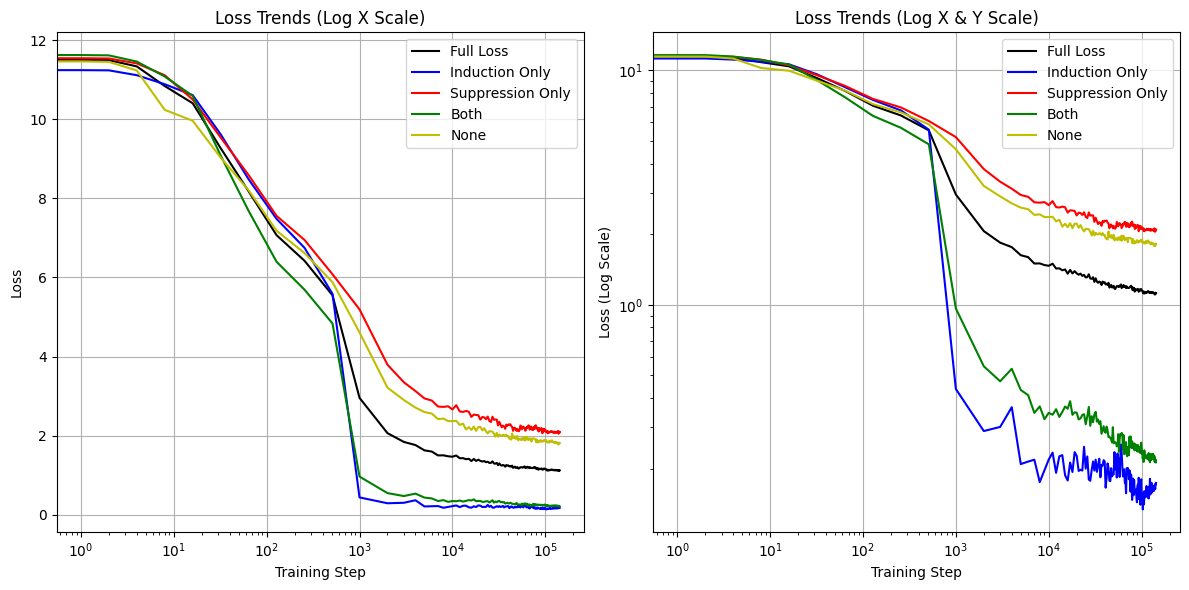

In [ ]:
def compute_induction_analysis(tokens, scores_df, column_prefix=None, step_column="step", pattern_filter=None):
    """
    Compute induction pattern analysis over multiple checkpoints.
    
    Args:
        tokens: List or array of tokens to analyze
        scores_df: DataFrame with loss scores for multiple checkpoints
        column_prefix: Prefix for the column names containing losses (e.g., "context_2_pos_")
                      If None, will try to detect automatically
        step_column: Name of the column containing checkpoint/step information
        pattern_filter: Optional function that takes (token_a, token_b, token_c=None) and returns
                       a boolean indicating whether to include the pattern
        
    Returns:
        Dictionary with analysis results
    """
    # Auto-detect column prefix if not provided
    if column_prefix is None:
        # Find columns that might contain position information
        pos_columns = [col for col in scores_df.columns if "pos_" in col]
        if pos_columns:
            # Extract the prefix from the first matching column
            parts = pos_columns[0].split("pos_")
            column_prefix = parts[0] + "pos_"
        else:
            raise ValueError("Could not automatically detect column prefix. Please specify it manually.")
    
    # Find induction patterns with the filter
    patterns = find_induction_patterns(tokens, pattern_filter)
    
    # Track which indices are part of induction and suppression patterns
    induction_indices = set()
    suppression_indices = set()
    
    # Fill the sets based on patterns
    for (token_a, token_b), indices in patterns.items():
        # Add indices to the respective sets
        induction_indices.update(indices['induction'])
        suppression_indices.update(indices['suppression'])
    
    # Find indices that appear in both sets
    both_indices = induction_indices.intersection(suppression_indices)
    induction_only_indices = induction_indices - both_indices
    suppression_only_indices = suppression_indices - both_indices
    
    # Add 1 to all indices to get the position of token B or C (not token A)
    induction_only_indices_next = {idx for idx in induction_only_indices}
    suppression_only_indices_next = {idx for idx in suppression_only_indices}
    both_indices_next = {idx for idx in both_indices}
    
    # Get all checkpoints (steps)
    checkpoints = scores_df[step_column].unique()
    checkpoints.sort()
    
    # Calculate masked losses for each checkpoint
    checkpoint_results = {}
    for step in checkpoints:
        step_df = scores_df[scores_df[step_column] == step]
        
        # Get all column names for the context
        context_columns = [col for col in step_df.columns if col.startswith(column_prefix)]
        
        # Calculate masked losses
        results = {}
        
        # Full loss (average of all positions)
        full_loss = step_df[context_columns].mean().mean()
        results['full_loss'] = full_loss
        
        # Masked losses for each category
        masked_losses = {}
        
        for col in context_columns:
            # Extract position from column name
            pos = int(col.split('_')[-1])
            
            # Check which category this position belongs to
            if pos in induction_only_indices_next:
                category = 'induction_only'
            elif pos in suppression_only_indices_next:
                category = 'suppression_only'
            elif pos in both_indices_next:
                category = 'both'
            else:
                category = 'none'
            
            # Add to the appropriate category
            if category not in masked_losses:
                masked_losses[category] = []
            
            masked_losses[category].extend(step_df[col].tolist())
        
        # Calculate average loss for each category
        for category, losses in masked_losses.items():
            if losses:  # Only calculate if there are values
                results[f'{category}_loss'] = sum(losses) / len(losses)
            else:
                results[f'{category}_loss'] = float('nan')
        
        # Add counts
        results['induction_only_count'] = len(induction_only_indices_next)
        results['suppression_only_count'] = len(suppression_only_indices_next)
        results['both_count'] = len(both_indices_next)
        results['total_tokens'] = len(tokens)
        
        checkpoint_results[step] = results
    
    # Create a DataFrame for easier analysis
    steps = []
    full_losses = []
    induction_only_losses = []
    suppression_only_losses = []
    both_losses = []
    none_losses = []
    
    for step, results in checkpoint_results.items():
        steps.append(step)
        full_losses.append(results['full_loss'])
        induction_only_losses.append(results.get('induction_only_loss', float('nan')))
        suppression_only_losses.append(results.get('suppression_only_loss', float('nan')))
        both_losses.append(results.get('both_loss', float('nan')))
        none_losses.append(results.get('none_loss', float('nan')))
    
    trends_df = pd.DataFrame({
        'step': steps,
        'full_loss': full_losses,
        'induction_only_loss': induction_only_losses,
        'suppression_only_loss': suppression_only_losses,
        'both_loss': both_losses,
        'none_loss': none_losses
    })
    
    return {
        'tokens': tokens,
        'patterns': patterns,
        'induction_indices': induction_indices,
        'suppression_indices': suppression_indices,
        'both_indices': both_indices,
        'induction_only_indices': induction_only_indices,
        'suppression_only_indices': suppression_only_indices,
        'checkpoint_results': checkpoint_results,
        'trends_df': trends_df,
        'filter_applied': pattern_filter is not None
    }

def analyze_induction_patterns_over_checkpoints(tokens, scores_df, column_prefix=None, step_column="step", pattern_filter=None, title=None):
    """
    Analyze induction patterns and calculate masked losses over multiple checkpoints for any dataset.
    
    Args:
        tokens: List or array of tokens to analyze
        scores_df: DataFrame with loss scores for multiple checkpoints
        column_prefix: Prefix for the column names containing losses (e.g., "context_2_pos_")
                      If None, will try to detect automatically
        step_column: Name of the column containing checkpoint/step information
        pattern_filter: Optional function that takes (token_a, token_b, token_c=None) and returns
                       a boolean indicating whether to include the pattern
        
    Returns:
        Dictionary with masked losses per checkpoint and visualizations
    """
    # Compute the analysis
    analysis_results = compute_induction_analysis(tokens, scores_df, column_prefix, step_column, pattern_filter)
    
    # Create visualizations
    display = visualize_induction_analysis(analysis_results, pattern_filter=pattern_filter, title=title)
    
    # Return both the analysis results and the display
    return {
        'analysis': analysis_results,
        'display': display
    }

# Example usage with a filter
def analyze_tokens_with_filter(context_idx=2, losses_df=None, pattern_filter=None):
    """
    Analyze tokens with a custom filter for patterns.
    
    Args:
        context_idx: Index of the tokens list to use
        losses_df: DataFrame with loss scores
        pattern_filter: Function that takes (token_a, token_b, token_c=None) and returns a boolean
        
    Returns:
        Dictionary with masked losses and HTML display
    """
    if losses_df is None:
        losses_df = github_6_9b
        
    tokens = github_tokens[context_idx]
    column_prefix = f"context_{context_idx}_pos_"
    
    return analyze_induction_patterns_over_checkpoints(tokens, losses_df, column_prefix, pattern_filter=pattern_filter, title=f"Context {context_idx}")

# Run the analysis with a filter
result = analyze_tokens_with_filter(2, github_6_9b)
result['display']

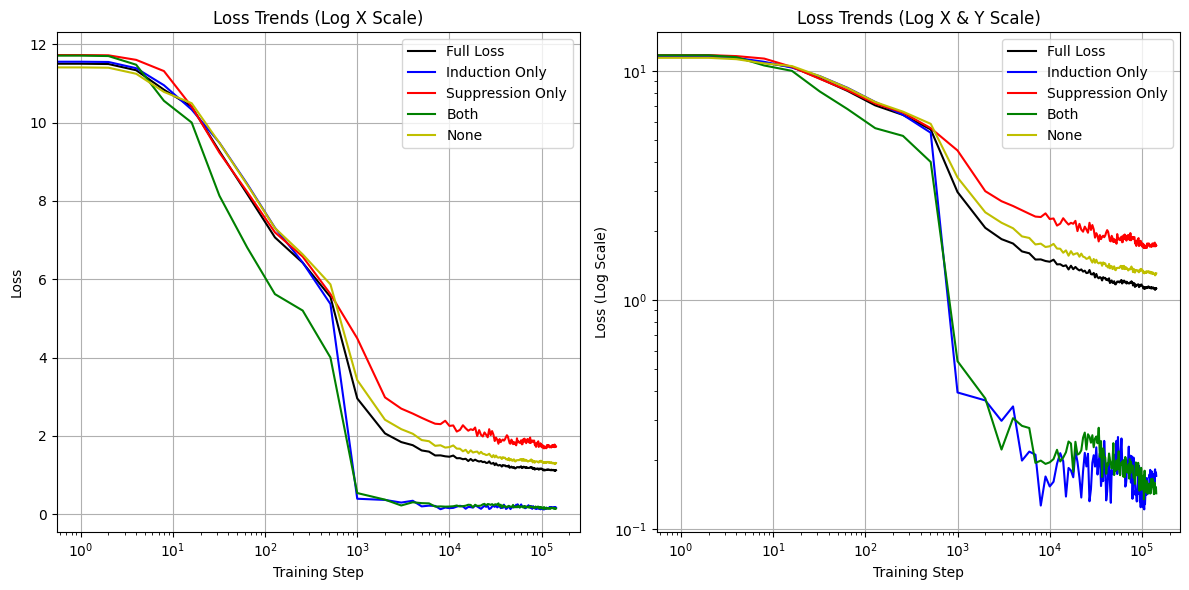

In [137]:
# Run the analysis with a filter
result = analyze_tokens_with_filter(2, github_6_9b, filter_for_punctuation)
result['display']

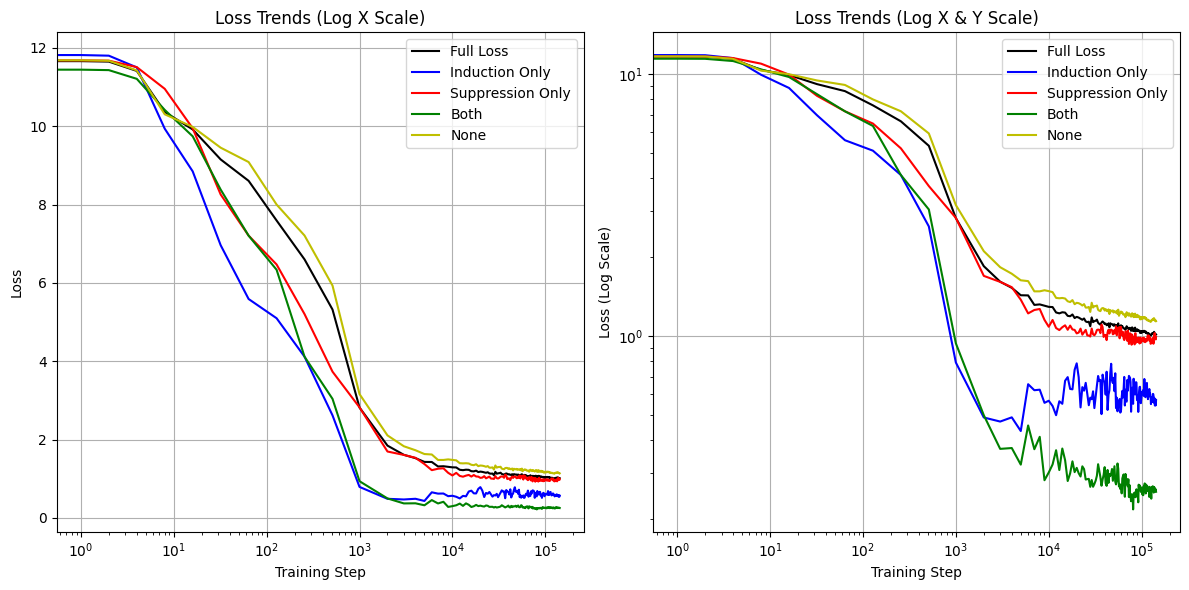

In [ ]:
result = analyze_tokens_with_filter(list(github_tokens.keys())[1], github_6_9b, filter_for_punctuation)
result['display']

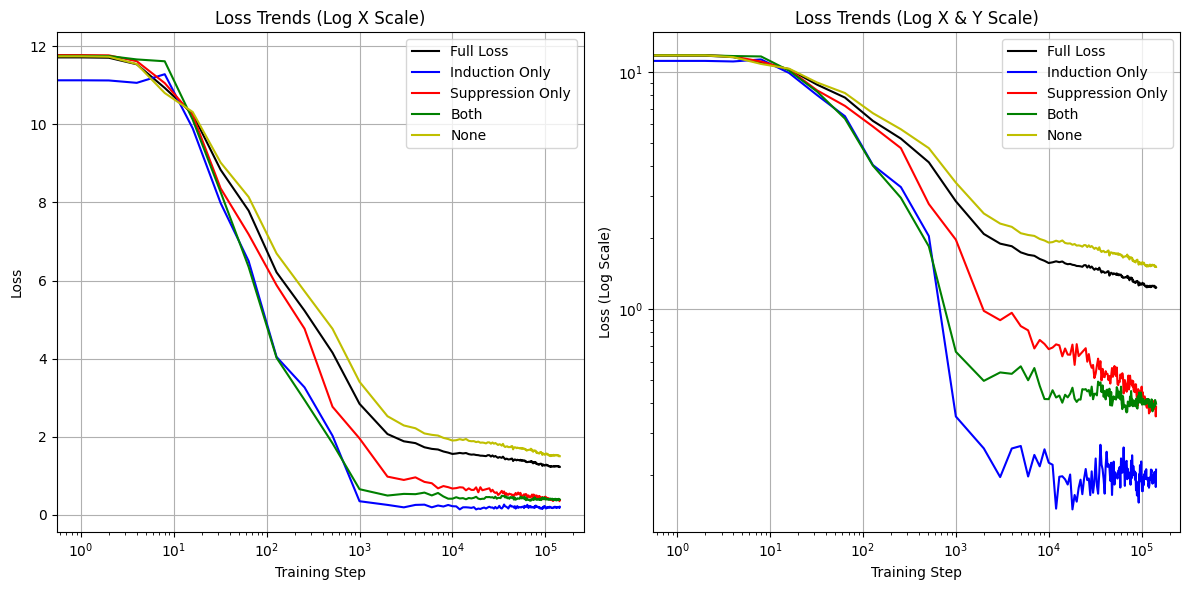

In [139]:
result = analyze_tokens_with_filter(list(github_tokens.keys())[2], github_6_9b, filter_for_punctuation)
result['display']

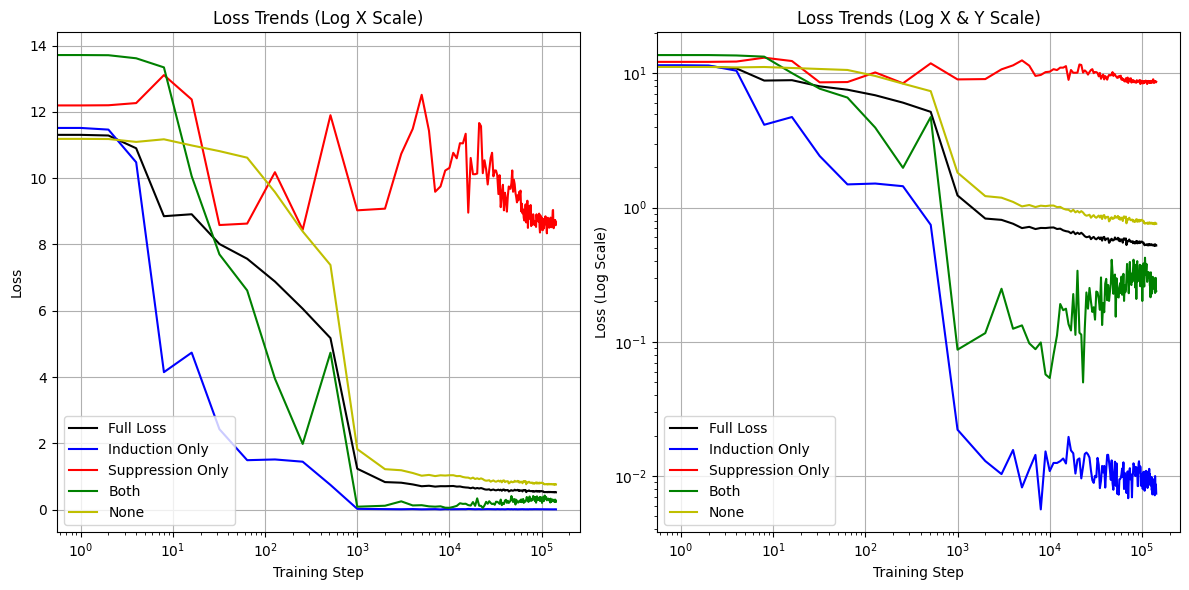

In [ ]:
result = analyze_tokens_with_filter(list(github_tokens.keys())[3], github_6_9b, filter_for_punctuation)
result['display']

Full loss at step 4000: 1.7615
Difficulty threshold: 1.9376
Found 2 difficult induction-only patterns out of 39
Found 36 difficult suppression-only patterns out of 70
Found 2 difficult both patterns out of 68


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 120 difficult non-pattern patterns out of 335


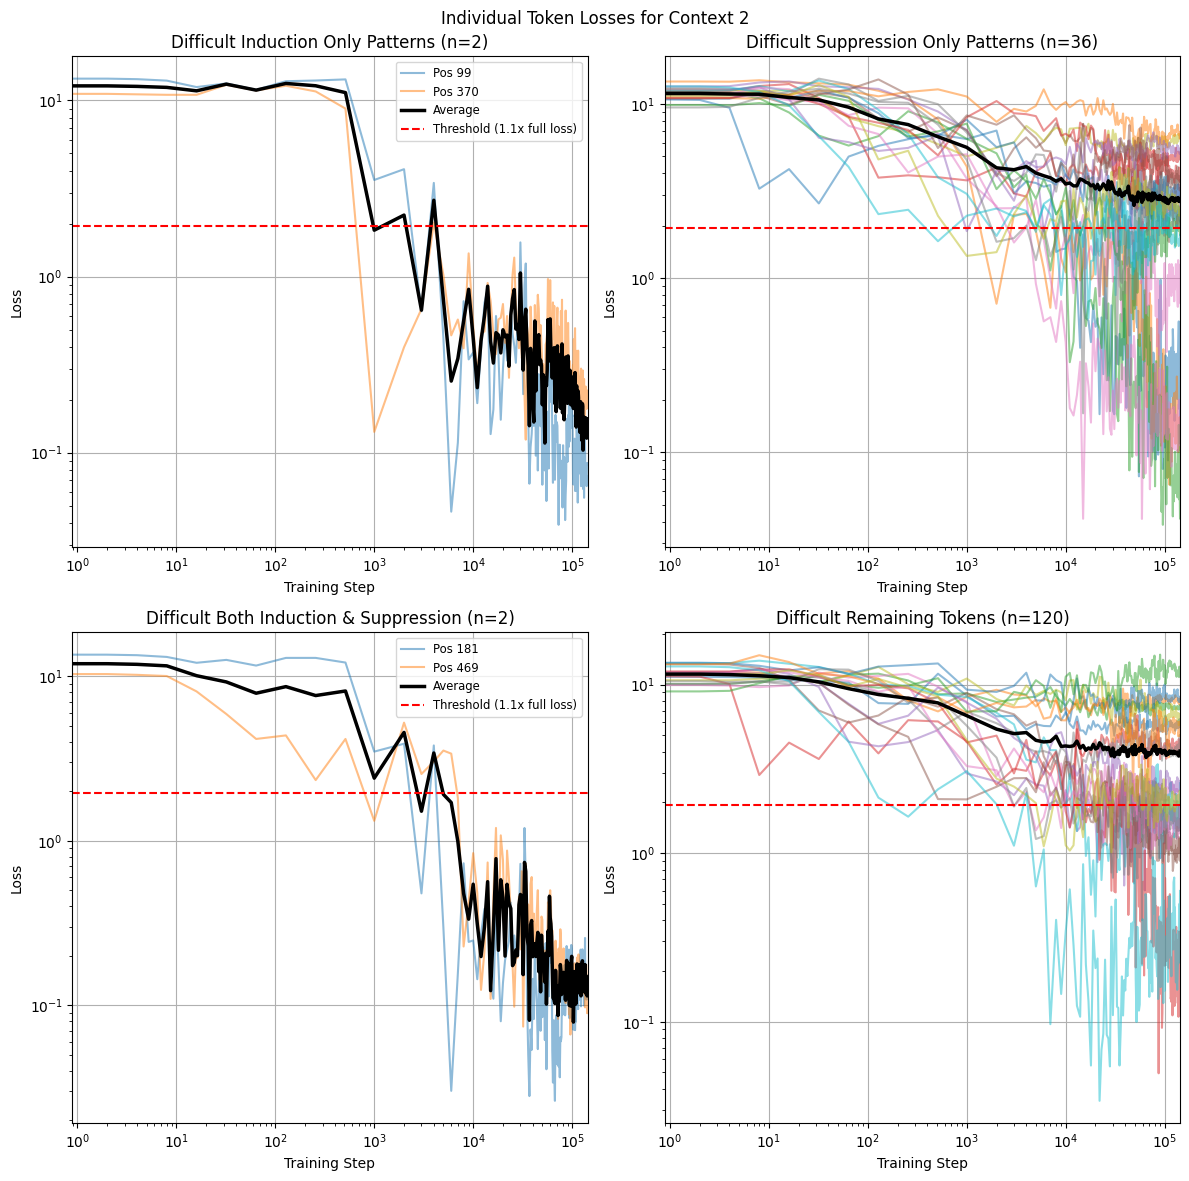

Full loss at step 4000: 1.5268
Difficulty threshold: 1.6795
Found 1 difficult induction-only patterns out of 16
Found 15 difficult suppression-only patterns out of 46
Found 5 difficult both patterns out of 55


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 132 difficult non-pattern patterns out of 395


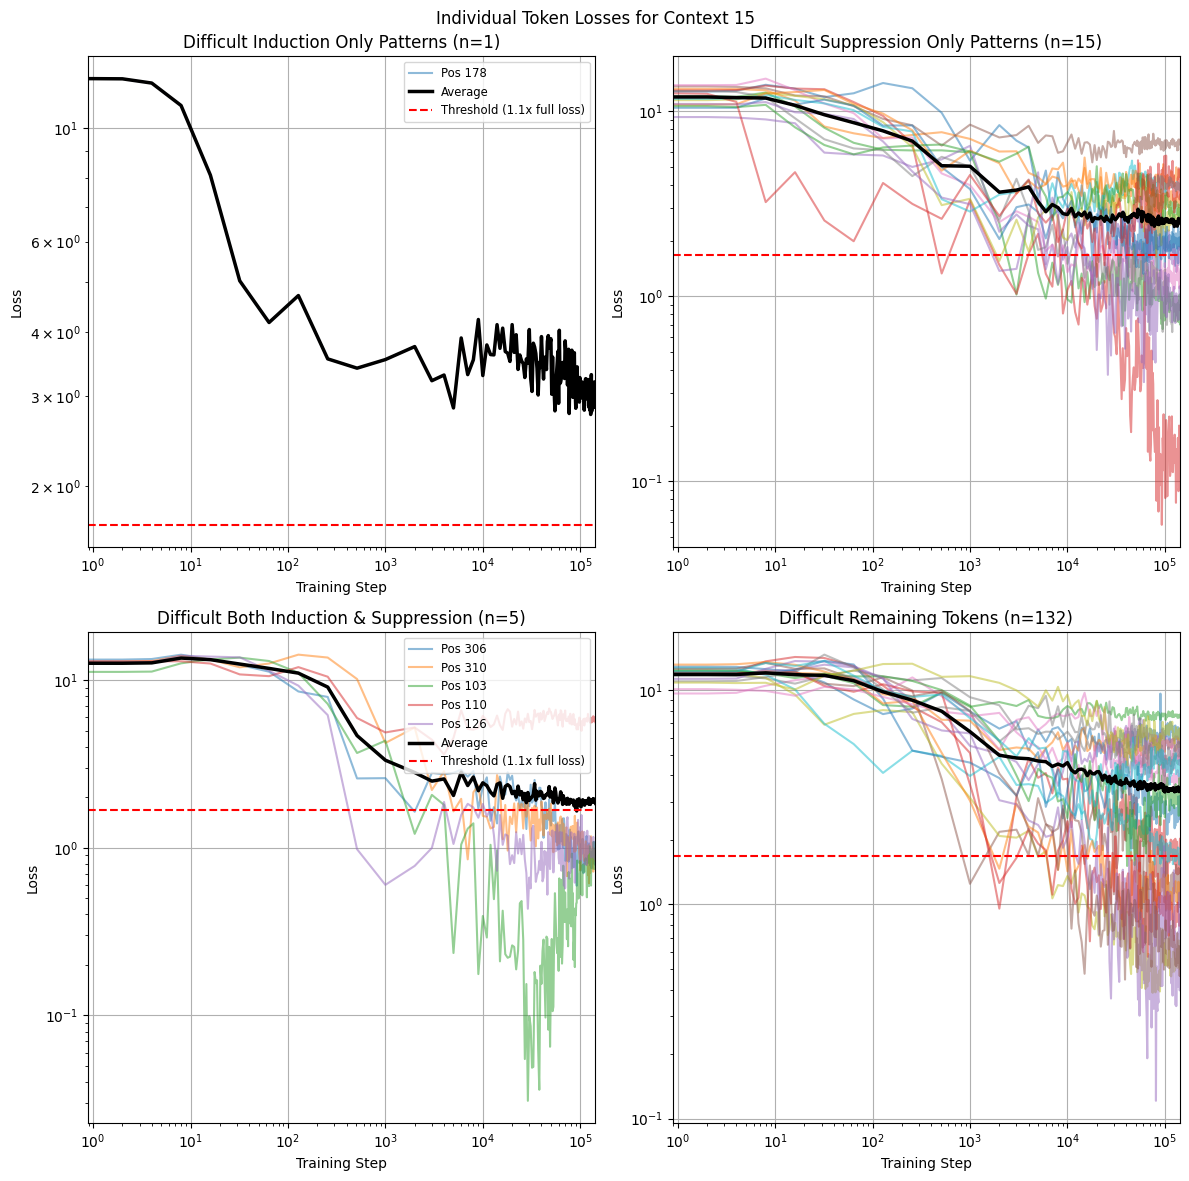

Full loss at step 4000: 1.8394
Difficulty threshold: 2.0233
Found 0 difficult induction-only patterns out of 26
Found 8 difficult suppression-only patterns out of 42
Found 3 difficult both patterns out of 54


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 135 difficult non-pattern patterns out of 390


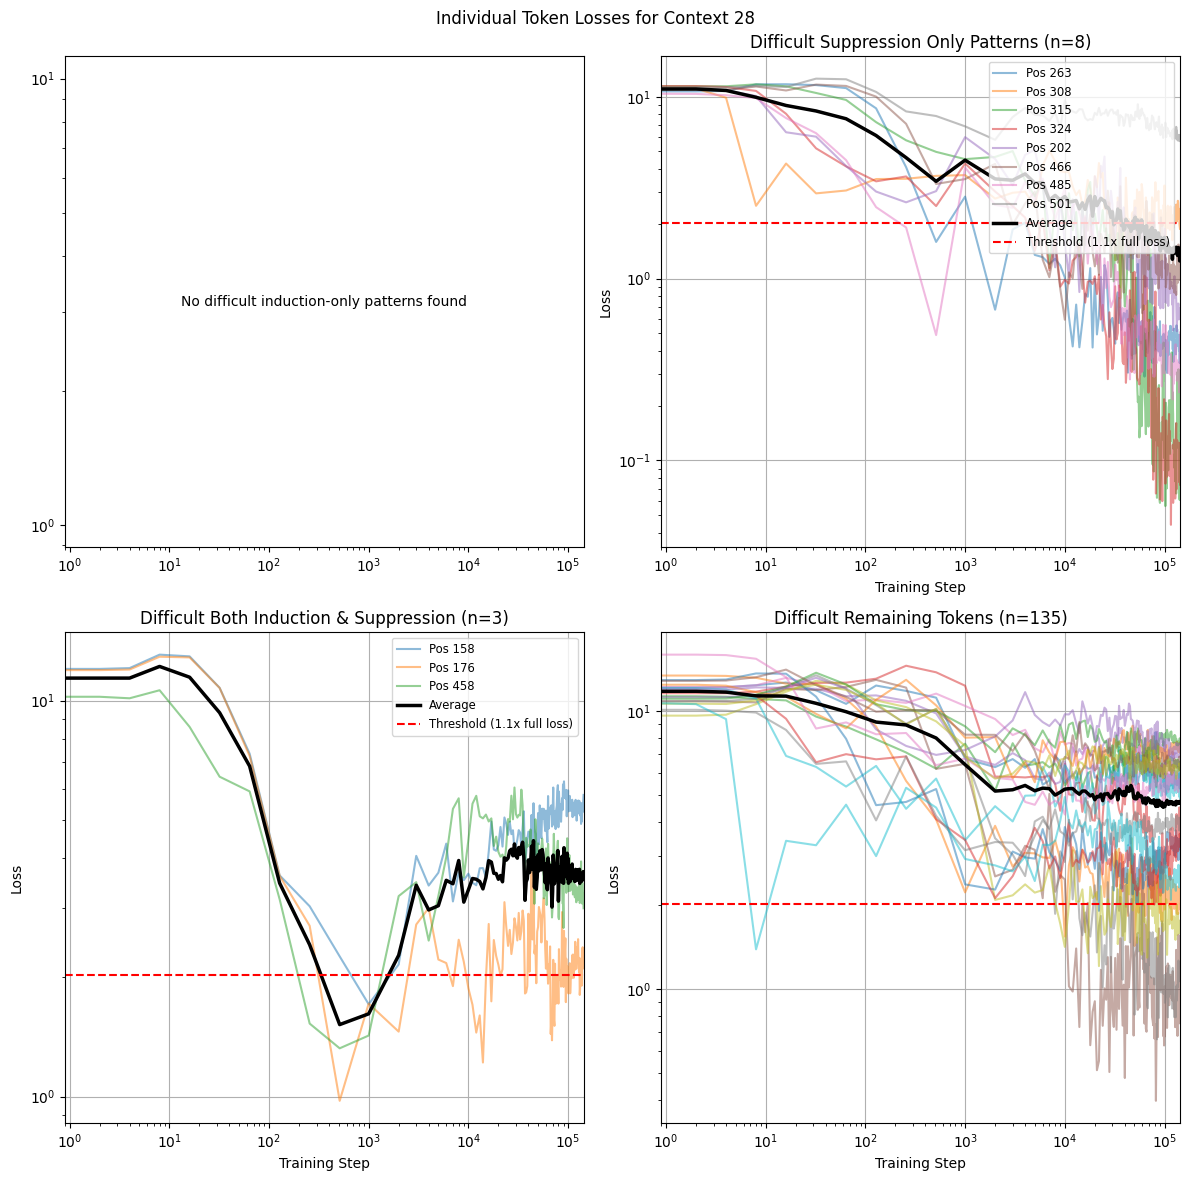

Full loss at step 4000: 0.7592
Difficulty threshold: 0.8351
Found 1 difficult induction-only patterns out of 170
Found 1 difficult suppression-only patterns out of 1
Found 0 difficult both patterns out of 2


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 66 difficult non-pattern patterns out of 339


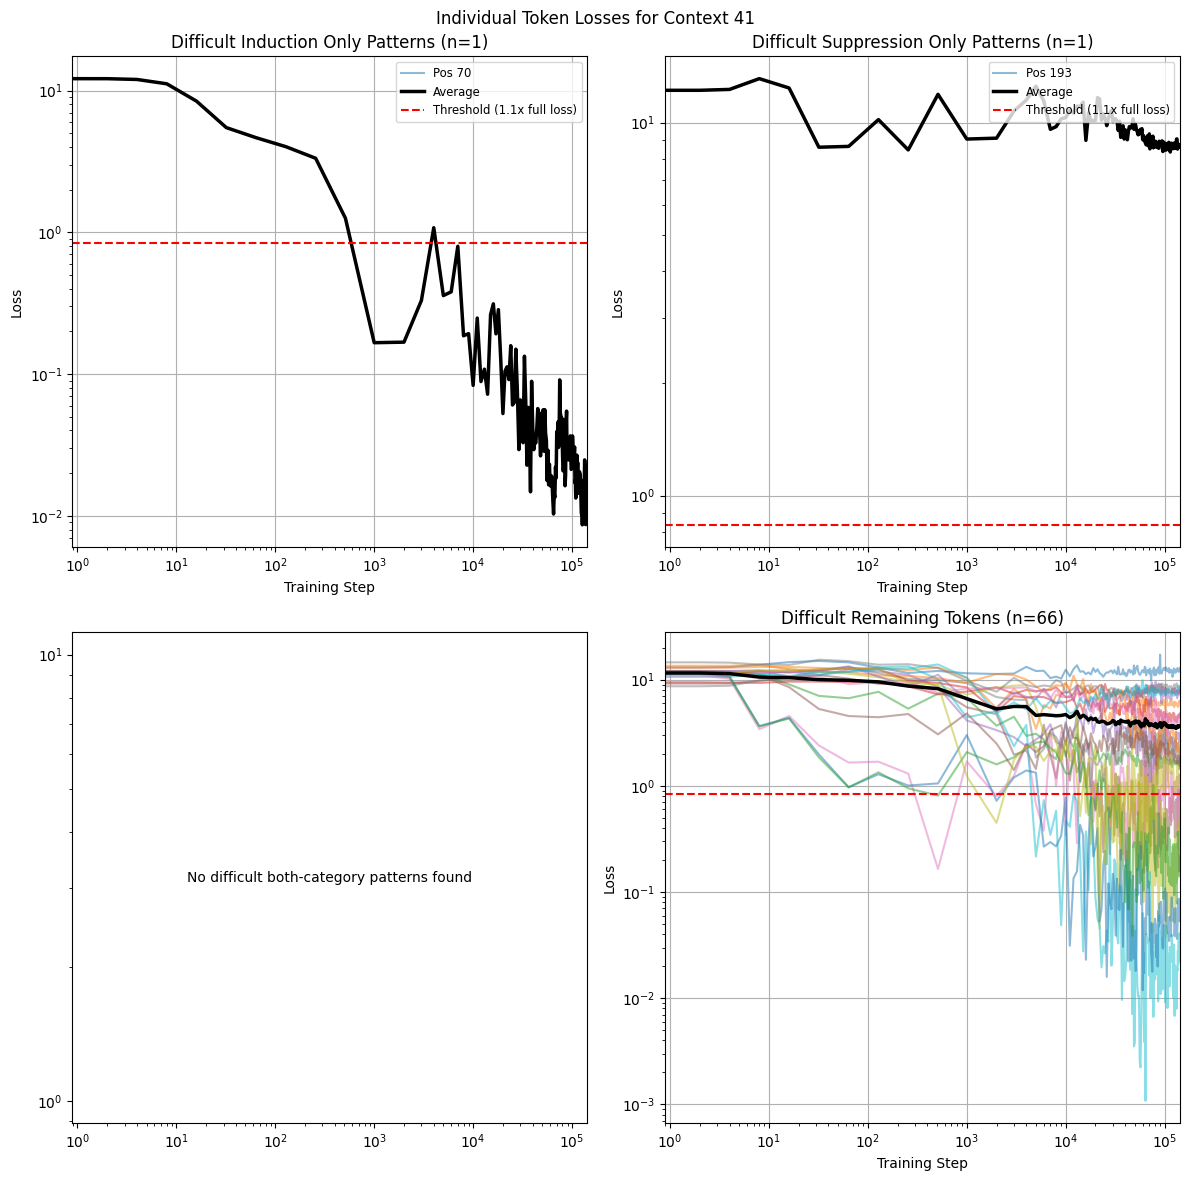

Full loss at step 4000: 1.9070
Difficulty threshold: 2.0977
Found 0 difficult induction-only patterns out of 28
Found 17 difficult suppression-only patterns out of 44
Found 3 difficult both patterns out of 46


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 135 difficult non-pattern patterns out of 394


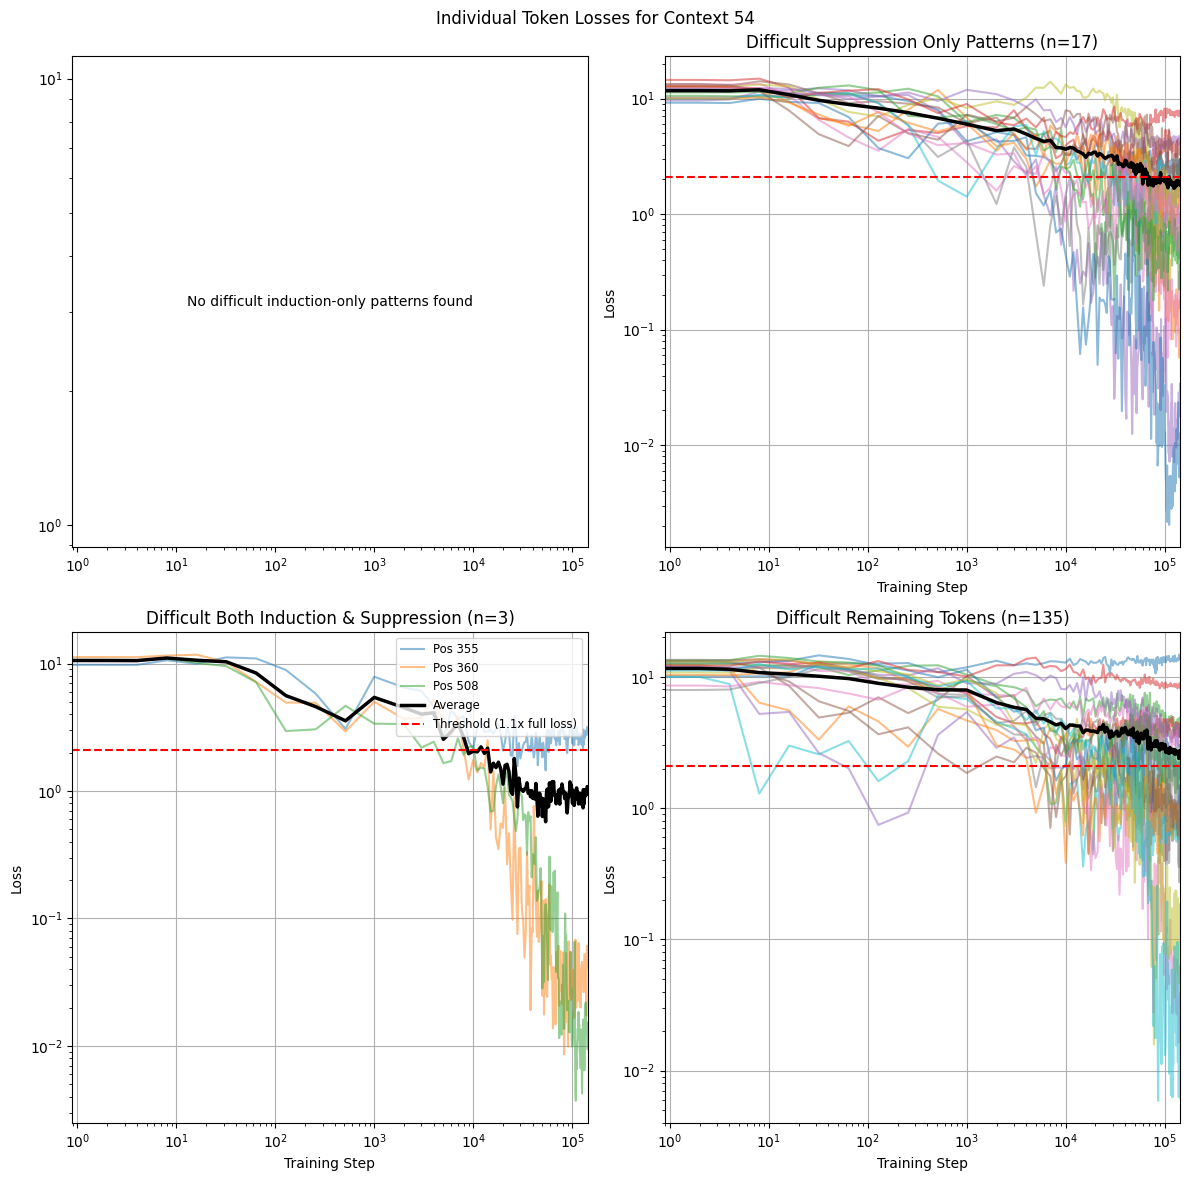

Full loss at step 4000: 0.9116
Difficulty threshold: 1.0028
Found 0 difficult induction-only patterns out of 13
Found 10 difficult suppression-only patterns out of 33
Found 4 difficult both patterns out of 34


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 117 difficult non-pattern patterns out of 432


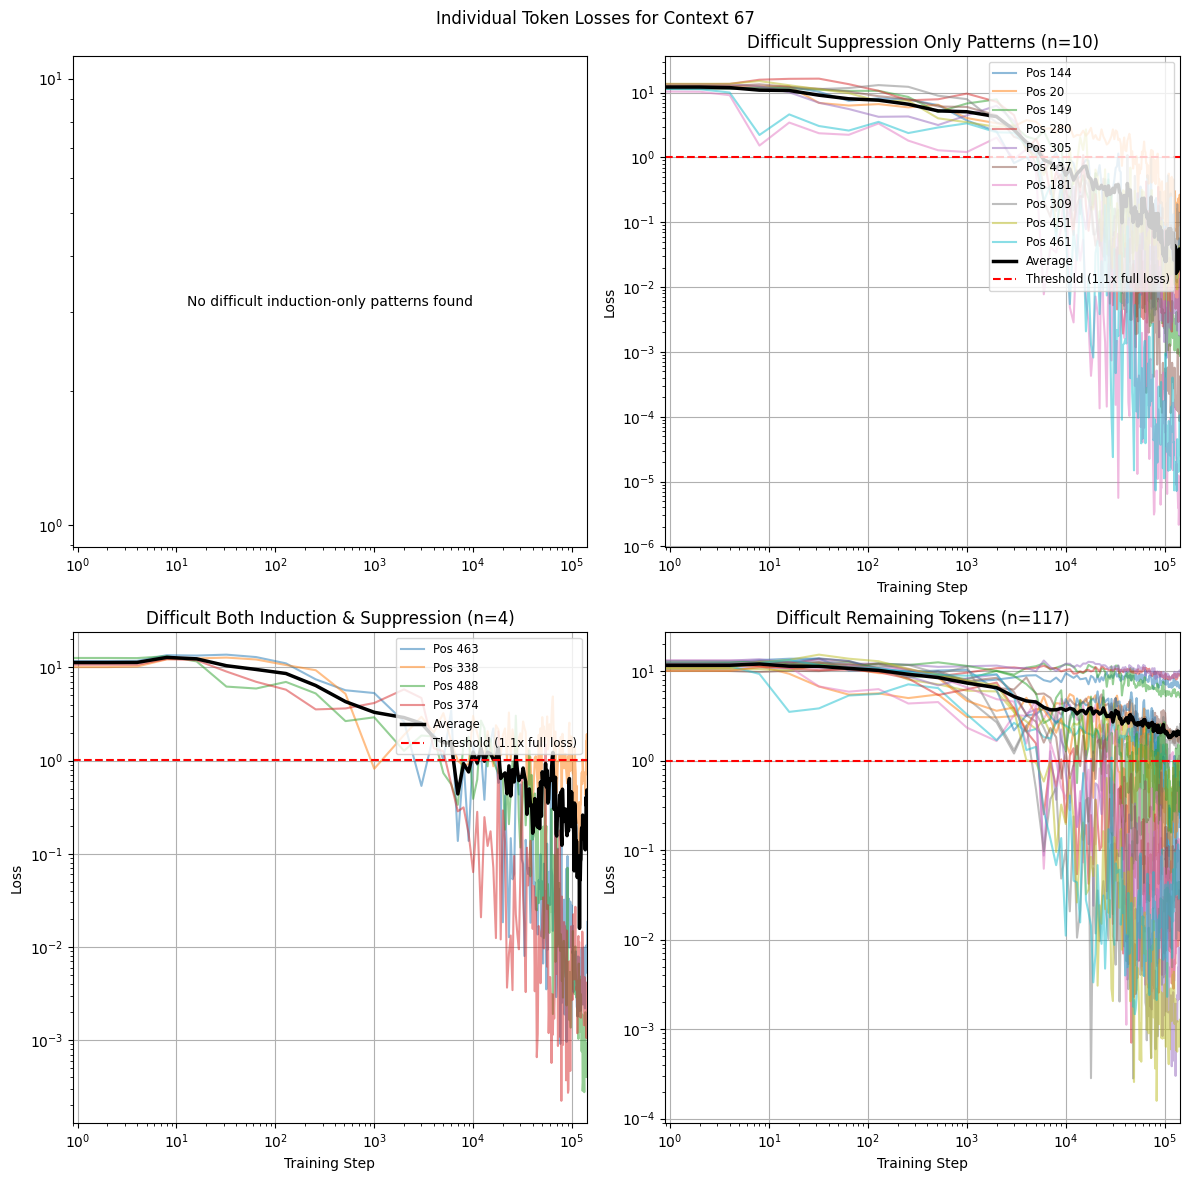

Full loss at step 4000: 2.3594
Difficulty threshold: 2.5953
Found 0 difficult induction-only patterns out of 20
Found 10 difficult suppression-only patterns out of 37
Found 3 difficult both patterns out of 32


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 161 difficult non-pattern patterns out of 423


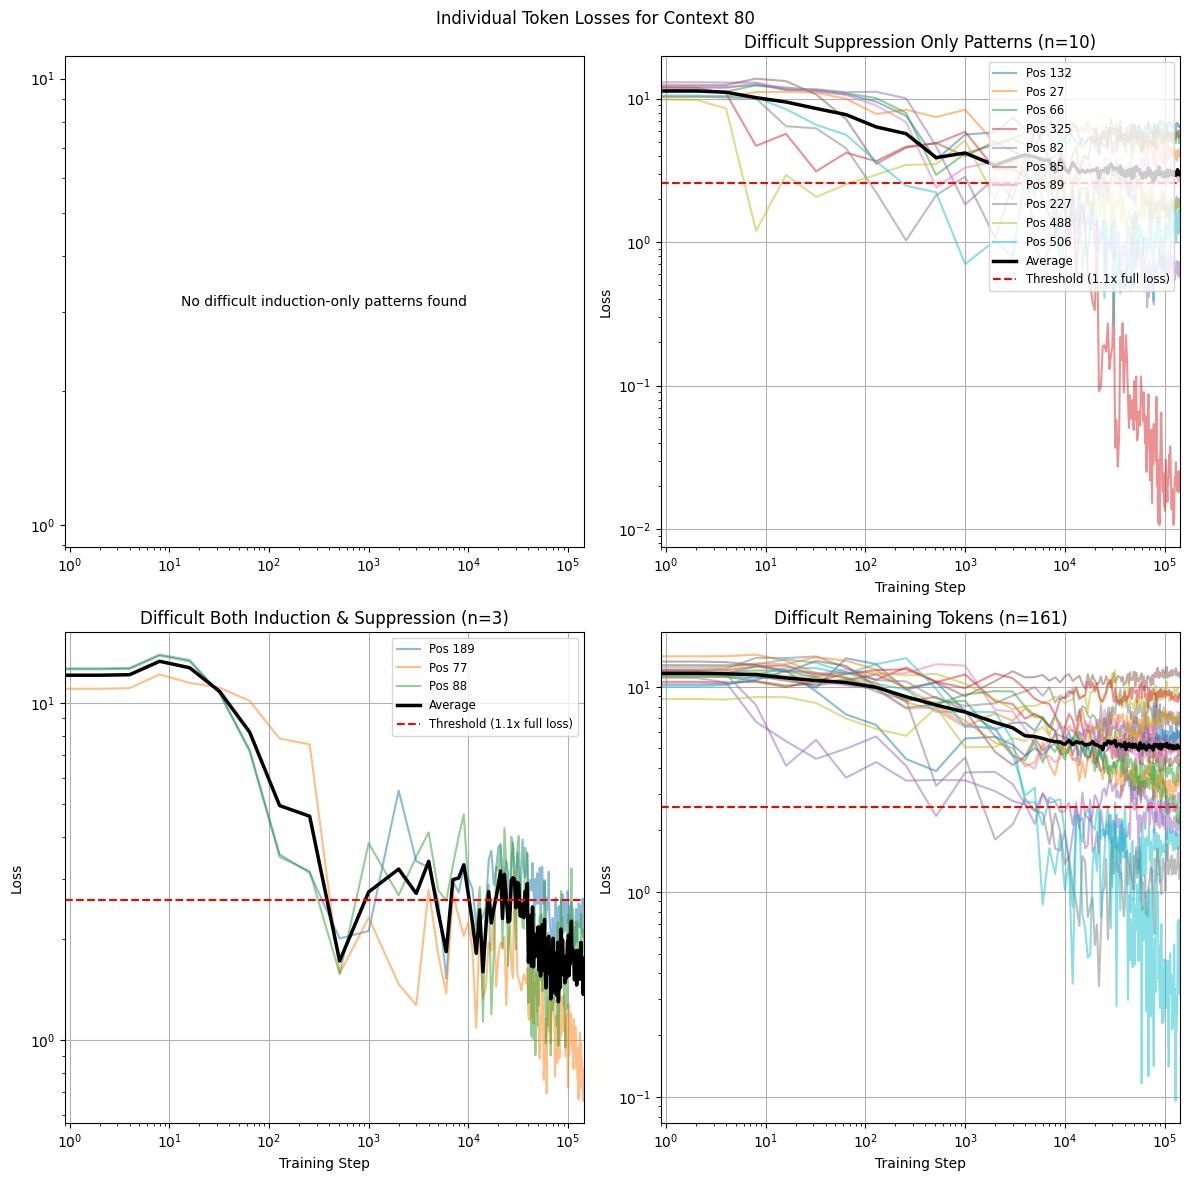

Full loss at step 4000: 0.1223
Difficulty threshold: 0.1345
Found 1 difficult induction-only patterns out of 26
Found 3 difficult suppression-only patterns out of 40
Found 1 difficult both patterns out of 22


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 53 difficult non-pattern patterns out of 424


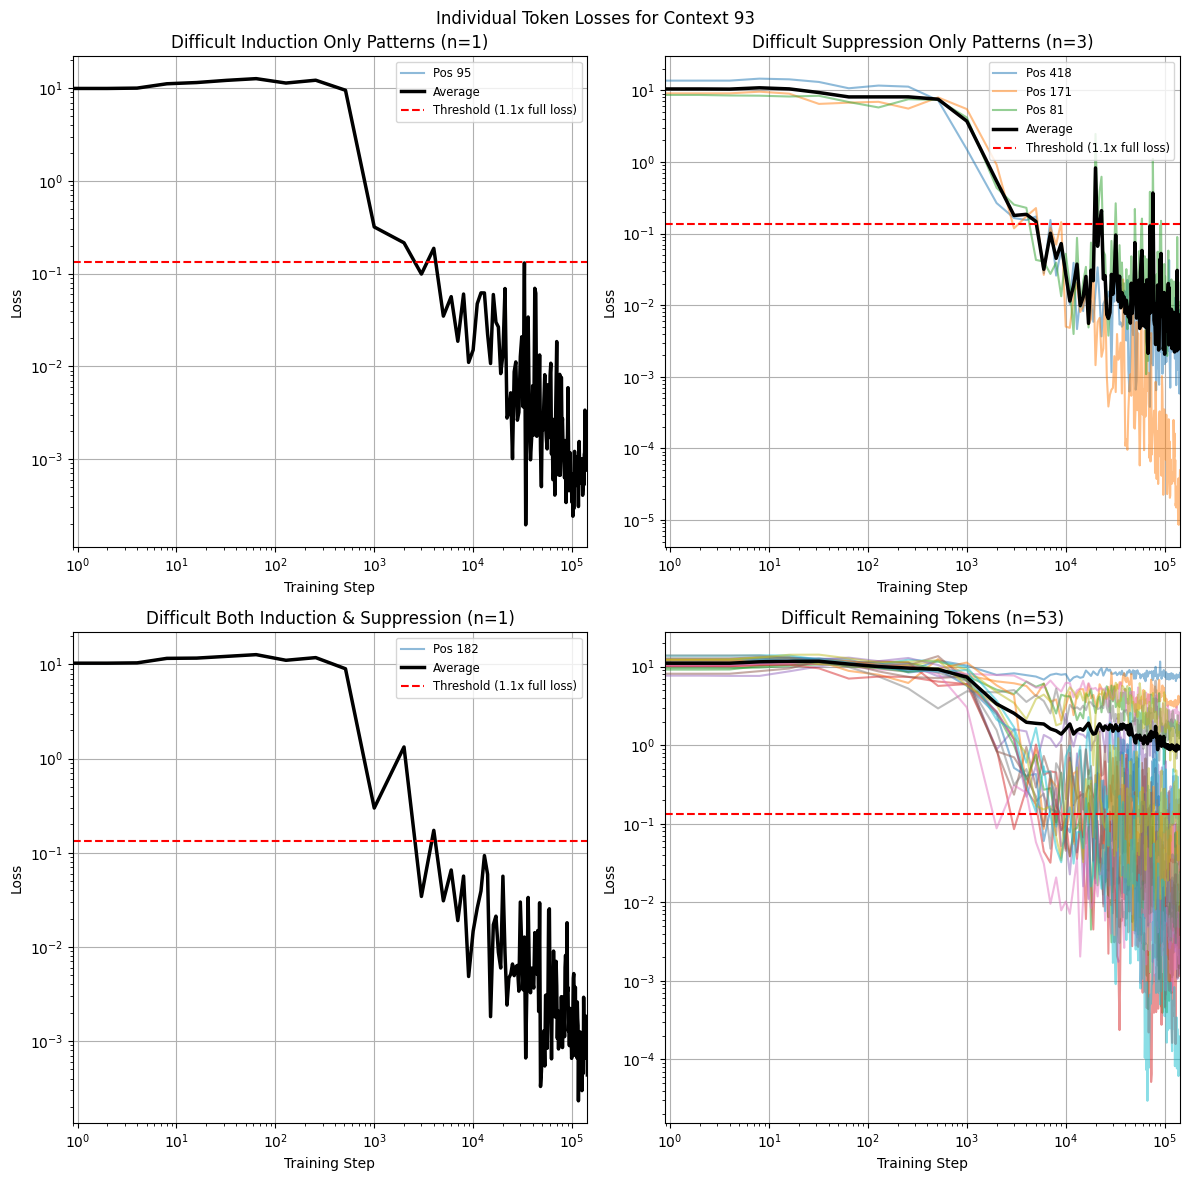

Full loss at step 4000: 1.2465
Difficulty threshold: 1.3711
Found 0 difficult induction-only patterns out of 39
Found 12 difficult suppression-only patterns out of 38
Found 1 difficult both patterns out of 28


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 122 difficult non-pattern patterns out of 407


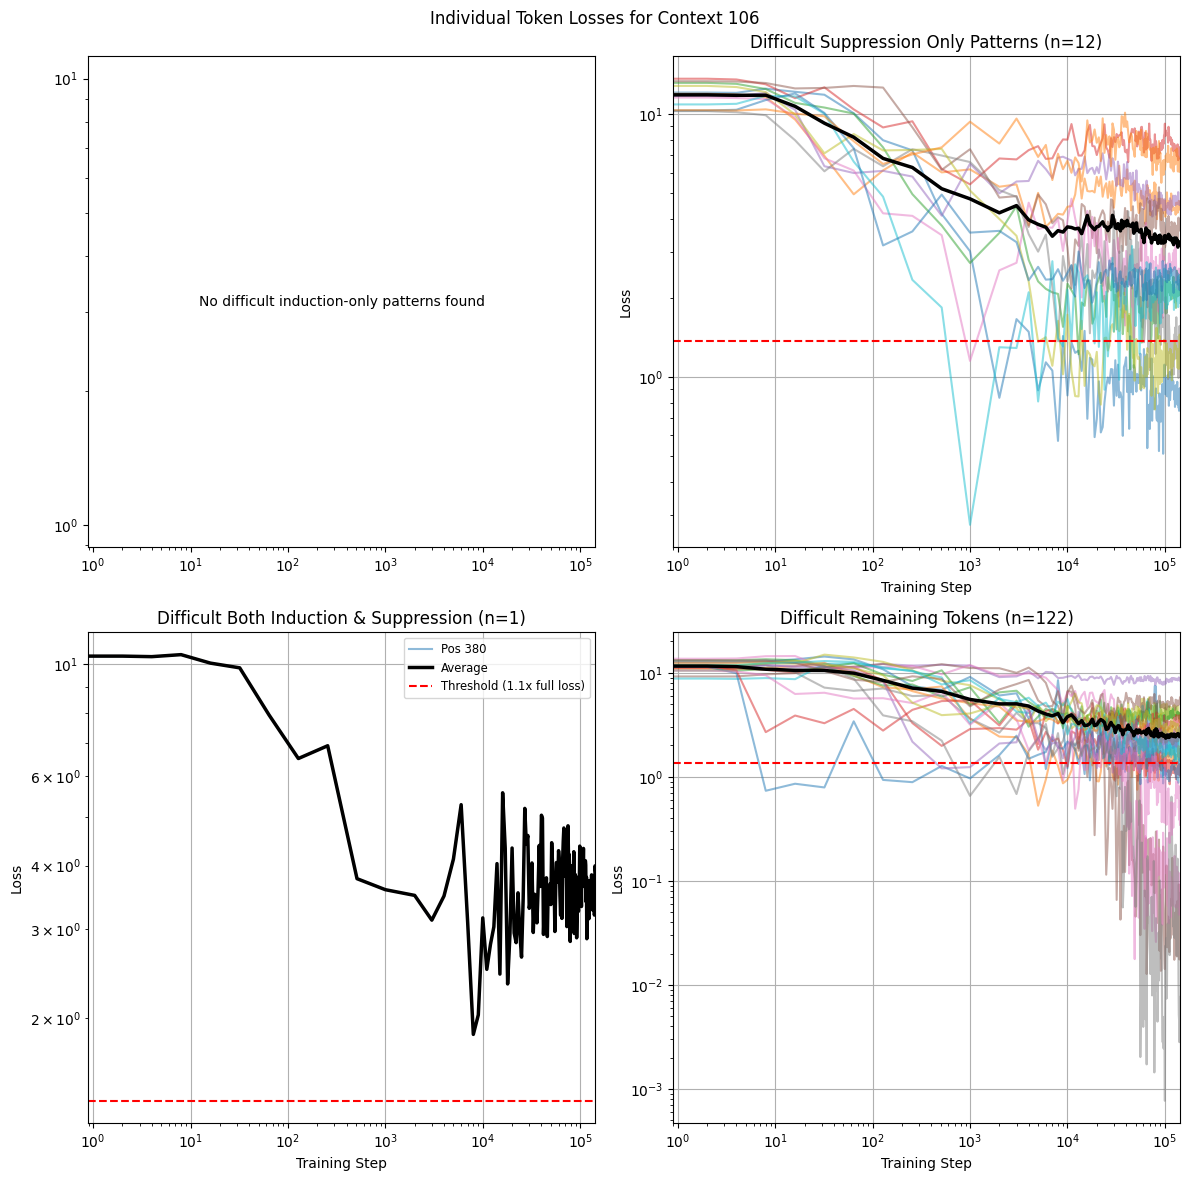

Full loss at step 4000: 0.6413
Difficulty threshold: 0.7054
Found 1 difficult induction-only patterns out of 49
Found 18 difficult suppression-only patterns out of 41
Found 0 difficult both patterns out of 141


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_48120/3174891091.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min(checkpoints), max(checkpoints))


Found 70 difficult non-pattern patterns out of 281


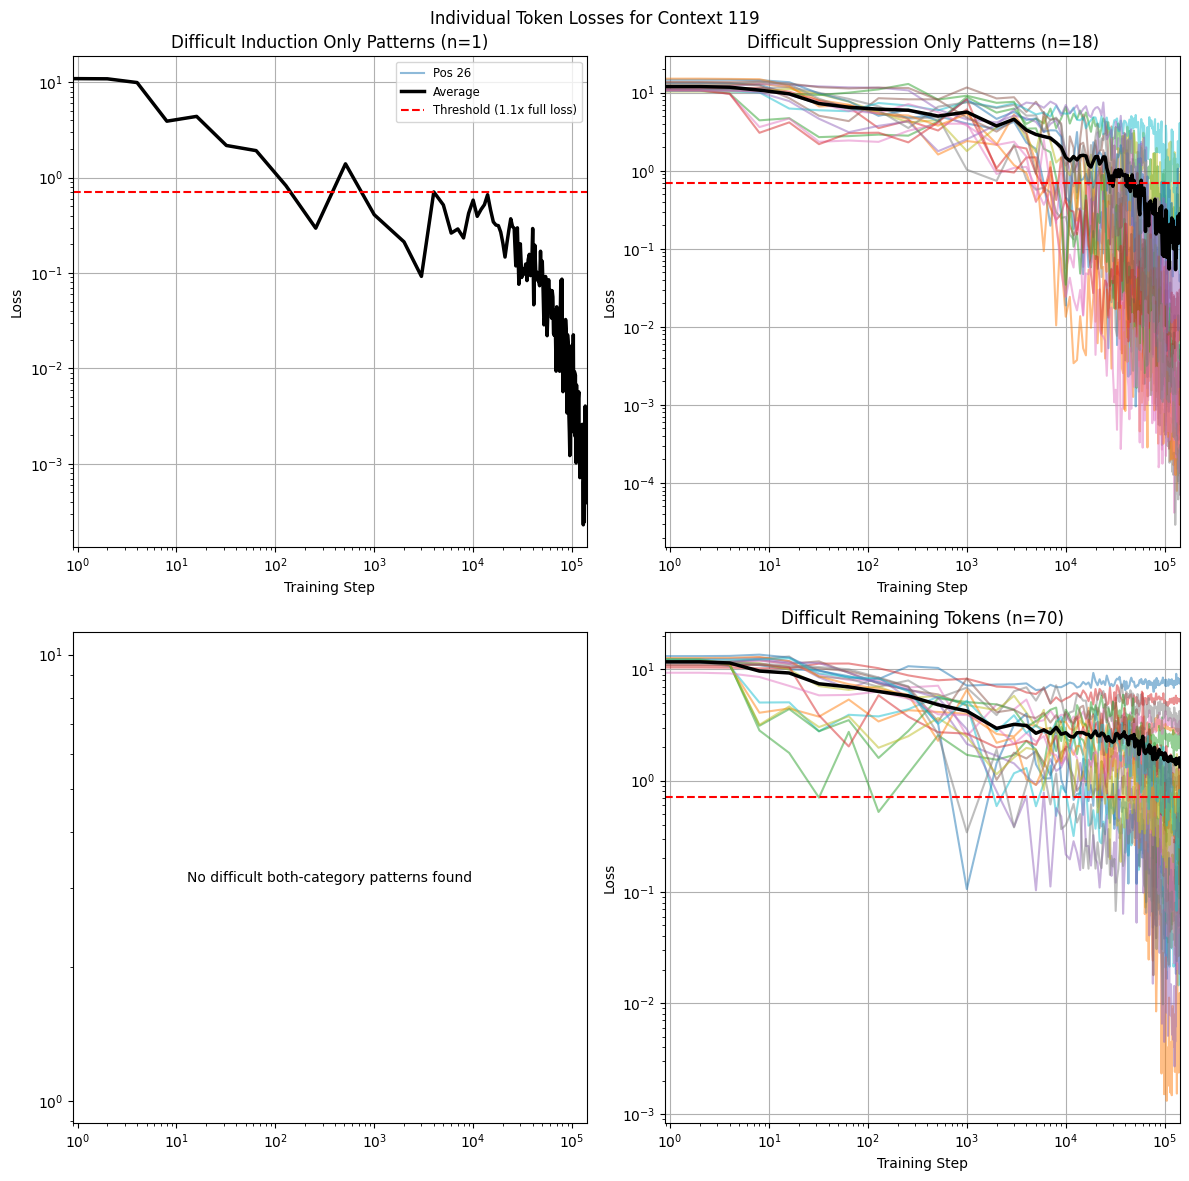

In [172]:
def plot_individual_pattern_losses(tokens, scores_df, column_prefix=None, step_column="step", pattern_filter=None, max_patterns=10, title=None, difficulty_filter_step=4000, difficulty_threshold=1.1):
    """
    Plot loss for individual induction, suppression, both patterns, and remaining tokens in four plots side by side.
    Filter for patterns that are still difficult at a specified step.
    
    Args:
        tokens: List or array of tokens to analyze
        scores_df: DataFrame with loss scores for multiple checkpoints
        column_prefix: Prefix for the column names containing losses (e.g., "context_2_pos_")
                      If None, will try to detect automatically
        step_column: Name of the column containing checkpoint/step information
        pattern_filter: Optional function that takes (token_a, token_b, token_c=None) and returns
                       a boolean indicating whether to include the pattern
        max_patterns: Maximum number of patterns to plot in each category
        title: Optional title for the plots
        difficulty_filter_step: Step at which to check if patterns are still difficult
        difficulty_threshold: Multiplier of full loss to consider a pattern "difficult"
        
    Returns:
        Figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Auto-detect column prefix if not provided
    if column_prefix is None:
        # Find columns that might contain position information
        pos_columns = [col for col in scores_df.columns if "pos_" in col]
        if pos_columns:
            # Extract the prefix from the first matching column
            parts = pos_columns[0].split("pos_")
            column_prefix = parts[0] + "pos_"
        else:
            raise ValueError("Could not automatically detect column prefix. Please specify it manually.")
    
    # Find induction patterns with the filter
    patterns = find_induction_patterns(tokens, pattern_filter)
    
    # Track which indices are part of induction and suppression patterns
    induction_indices = set()
    suppression_indices = set()
    
    # Fill the sets based on patterns
    for (token_a, token_b), indices in patterns.items():
        # Add indices to the respective sets
        induction_indices.update(indices['induction'])
        suppression_indices.update(indices['suppression'])
    
    # Find indices that appear in both sets
    both_indices = induction_indices.intersection(suppression_indices)
    induction_only_indices = induction_indices - both_indices
    suppression_only_indices = suppression_indices - both_indices
    
    # Add 1 to all indices to get the position of token B or C (not token A)
    induction_only_indices_next = {idx for idx in induction_only_indices}
    suppression_only_indices_next = {idx for idx in suppression_only_indices}
    both_indices_next = {idx for idx in both_indices}
    
    # Create a figure with four subplots side by side
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    
    # Get all checkpoints (steps)
    checkpoints = scores_df[step_column].unique()
    checkpoints.sort()
    
    # Get the full loss at the difficulty filter step
    filter_step_df = scores_df[scores_df[step_column] == difficulty_filter_step]
    if len(filter_step_df) == 0:
        # If exact step not found, find the closest one
        available_steps = np.array(scores_df[step_column].unique())
        closest_step = available_steps[np.abs(available_steps - difficulty_filter_step).argmin()]
        filter_step_df = scores_df[scores_df[step_column] == closest_step]
        print(f"Exact step {difficulty_filter_step} not found, using closest step {closest_step} instead")
        difficulty_filter_step = closest_step
    
    context_columns = [col for col in filter_step_df.columns if col.startswith(column_prefix)]
    full_loss_at_filter_step = filter_step_df[context_columns].mean().mean()
    difficulty_loss_threshold = full_loss_at_filter_step * difficulty_threshold
    
    print(f"Full loss at step {difficulty_filter_step}: {full_loss_at_filter_step:.4f}")
    print(f"Difficulty threshold: {difficulty_loss_threshold:.4f}")

    for ax in (ax1, ax2, ax3, ax4):
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlim(min(checkpoints), max(checkpoints))
    
    # Function to filter difficult patterns
    def filter_difficult_patterns(indices, category_name):
        difficult_indices = []
        for pos in indices:
            pos_col = f"{column_prefix}{pos}"
            if pos_col in filter_step_df.columns:
                loss_value = filter_step_df[pos_col].mean()
                if loss_value > difficulty_loss_threshold:
                    difficult_indices.append(pos)
        
        print(f"Found {len(difficult_indices)} difficult {category_name} patterns out of {len(indices)}")
        return difficult_indices
    
    # Filter for difficult patterns in each category
    difficult_induction = filter_difficult_patterns(induction_only_indices_next, "induction-only")
    difficult_suppression = filter_difficult_patterns(suppression_only_indices_next, "suppression-only")
    difficult_both = filter_difficult_patterns(both_indices_next, "both")
    
    # Plot individual induction patterns
    if difficult_induction:
        indices_to_plot = difficult_induction[:max_patterns]
        all_induction_losses = {}  # Dictionary to store losses by step for averaging
        
        for i, pos in enumerate(indices_to_plot):
            steps = []
            losses = []
            
            for step in checkpoints:
                step_df = scores_df[scores_df[step_column] == step]
                
                # Find the column for this position
                pos_col = f"{column_prefix}{pos}"
                if pos_col in step_df.columns:
                    steps.append(step)
                    loss_value = step_df[pos_col].mean()
                    losses.append(loss_value)
                    
                    # Store for averaging
                    if step not in all_induction_losses:
                        all_induction_losses[step] = []
                    all_induction_losses[step].append(loss_value)
            
            if steps:  # Only plot if we have data
                color = plt.cm.tab10(i % 10)
                ax1.plot(steps, losses, '-', color=color, alpha=0.5, label=f'Pos {pos}')
        
        # Plot average line for induction patterns
        if all_induction_losses:
            avg_steps = []
            avg_losses = []
            for step in sorted(all_induction_losses.keys()):
                if all_induction_losses[step]:  # Only if we have values
                    avg_steps.append(step)
                    avg_losses.append(np.mean(all_induction_losses[step]))
            
            if avg_steps:
                ax1.plot(avg_steps, avg_losses, 'k-', linewidth=2.5, label='Average')
        
        # Plot the difficulty threshold line
        ax1.axhline(y=difficulty_loss_threshold, color='r', linestyle='--', 
                   label=f'Threshold ({difficulty_threshold}x full loss)')
        
        ax1.set_xlabel('Training Step')
        ax1.set_ylabel('Loss')
        ax1.set_title(f'Difficult Induction Only Patterns (n={len(difficult_induction)})')
        if len(indices_to_plot) <= 10:
            ax1.legend(loc='upper right', fontsize='small')
        ax1.grid(True)
    else:
        ax1.text(0.5, 0.5, 'No difficult induction-only patterns found', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax1.transAxes)
    
    # Plot individual suppression patterns
    if difficult_suppression:
        indices_to_plot = difficult_suppression[:max_patterns]
        all_suppression_losses = {}  # Dictionary to store losses by step for averaging
        
        for i, pos in enumerate(indices_to_plot):
            steps = []
            losses = []
            
            for step in checkpoints:
                step_df = scores_df[scores_df[step_column] == step]
                
                # Find the column for this position
                pos_col = f"{column_prefix}{pos}"
                if pos_col in step_df.columns:
                    steps.append(step)
                    loss_value = step_df[pos_col].mean()
                    losses.append(loss_value)
                    
                    # Store for averaging
                    if step not in all_suppression_losses:
                        all_suppression_losses[step] = []
                    all_suppression_losses[step].append(loss_value)
            
            if steps:  # Only plot if we have data
                color = plt.cm.tab10(i % 10)
                ax2.plot(steps, losses, '-', color=color, alpha=0.5, label=f'Pos {pos}')
        
        # Plot average line for suppression patterns
        if all_suppression_losses:
            avg_steps = []
            avg_losses = []
            for step in sorted(all_suppression_losses.keys()):
                if all_suppression_losses[step]:  # Only if we have values
                    avg_steps.append(step)
                    avg_losses.append(np.mean(all_suppression_losses[step]))
            
            if avg_steps:
                ax2.plot(avg_steps, avg_losses, 'k-', linewidth=2.5, label='Average')
        
        # Plot the difficulty threshold line
        ax2.axhline(y=difficulty_loss_threshold, color='r', linestyle='--', 
                   label=f'Threshold ({difficulty_threshold}x full loss)')
        
        ax2.set_xlabel('Training Step')
        ax2.set_ylabel('Loss')
        ax2.set_title(f'Difficult Suppression Only Patterns (n={len(difficult_suppression)})')
        if len(indices_to_plot) <= 10:
            ax2.legend(loc='upper right', fontsize='small')
        ax2.grid(True)
    else:
        ax2.text(0.5, 0.5, 'No difficult suppression-only patterns found', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax2.transAxes)
    
    # Plot individual both patterns
    if difficult_both:
        indices_to_plot = difficult_both[:max_patterns]
        all_both_losses = {}  # Dictionary to store losses by step for averaging
        
        for i, pos in enumerate(indices_to_plot):
            steps = []
            losses = []
            
            for step in checkpoints:
                step_df = scores_df[scores_df[step_column] == step]
                
                # Find the column for this position
                pos_col = f"{column_prefix}{pos}"
                if pos_col in step_df.columns:
                    steps.append(step)
                    loss_value = step_df[pos_col].mean()
                    losses.append(loss_value)
                    
                    # Store for averaging
                    if step not in all_both_losses:
                        all_both_losses[step] = []
                    all_both_losses[step].append(loss_value)
            
            if steps:  # Only plot if we have data
                color = plt.cm.tab10(i % 10)
                ax3.plot(steps, losses, '-', color=color, alpha=0.5, label=f'Pos {pos}')
        
        # Plot average line for both patterns
        if all_both_losses:
            avg_steps = []
            avg_losses = []
            for step in sorted(all_both_losses.keys()):
                if all_both_losses[step]:  # Only if we have values
                    avg_steps.append(step)
                    avg_losses.append(np.mean(all_both_losses[step]))
            
            if avg_steps:
                ax3.plot(avg_steps, avg_losses, 'k-', linewidth=2.5, label='Average')
        
        # Plot the difficulty threshold line
        ax3.axhline(y=difficulty_loss_threshold, color='r', linestyle='--', 
                   label=f'Threshold ({difficulty_threshold}x full loss)')
        
        ax3.set_xlabel('Training Step')
        ax3.set_ylabel('Loss')
        ax3.set_title(f'Difficult Both Induction & Suppression (n={len(difficult_both)})')
        if len(indices_to_plot) <= 10:
            ax3.legend(loc='upper right', fontsize='small')
        ax3.grid(True)
    else:
        ax3.text(0.5, 0.5, 'No difficult both-category patterns found', 
                 horizontalalignment='center', verticalalignment='center',
                 transform=ax3.transAxes)
    
    # Plot remaining tokens (none category)
    # Find positions that are not in any of the pattern categories
    all_pattern_positions = induction_only_indices_next.union(suppression_only_indices_next).union(both_indices_next)
    none_positions = set(range(len(tokens))) - all_pattern_positions
    
    # Filter for difficult none positions
    difficult_none = filter_difficult_patterns(none_positions, "non-pattern")
    
    # Limit to max_patterns
    none_positions_to_plot = difficult_none[:max_patterns]
    all_none_losses = {}  # Dictionary to store losses by step for averaging
    
    for i, pos in enumerate(none_positions_to_plot):
        steps = []
        losses = []
        
        for step in checkpoints:
            step_df = scores_df[scores_df[step_column] == step]
            
            # Find the column for this position
            pos_col = f"{column_prefix}{pos}"
            if pos_col in step_df.columns:
                steps.append(step)
                loss_value = step_df[pos_col].mean()
                losses.append(loss_value)
                
                # Store for averaging
                if step not in all_none_losses:
                    all_none_losses[step] = []
                all_none_losses[step].append(loss_value)
        
        if steps:  # Only plot if we have data
            color = plt.cm.tab10(i % 10)
            ax4.plot(steps, losses, '-', color=color, alpha=0.5, label=f'Pos {pos}')
    
    # Plot average line for none patterns
    if all_none_losses:
        avg_steps = []
        avg_losses = []
        for step in sorted(all_none_losses.keys()):
            if all_none_losses[step]:  # Only if we have values
                avg_steps.append(step)
                avg_losses.append(np.mean(all_none_losses[step]))
        
        if avg_steps:
            ax4.plot(avg_steps, avg_losses, 'k-', linewidth=2.5, label='Average')
    
    # Plot the difficulty threshold line
    ax4.axhline(y=difficulty_loss_threshold, color='r', linestyle='--', 
               label=f'Threshold ({difficulty_threshold}x full loss)')
    
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('Loss')
    ax4.set_title(f'Difficult Remaining Tokens (n={len(difficult_none)})')
    if len(none_positions_to_plot) <= 10:
        ax4.legend(loc='upper right', fontsize='small')
    ax4.grid(True)
    
    if title:
        plt.suptitle(title)
    
    plt.tight_layout()
    
    return fig

for i in list(github_tokens.keys())[:10]:
    # Then plot individual patterns
    fig = plot_individual_pattern_losses(
        tokens=github_tokens[i],
        scores_df=github_6_9b,
        column_prefix=f"context_{i}_pos_",
        title=f"Individual Token Losses for Context {i}",
        pattern_filter=filter_for_punctuation,
        max_patterns=20
    )
    plt.show()

In [177]:
def find_near_induction_patterns(input_ids, tokenizer=None, similarity_threshold=0.7, pattern_filter=None):
    """
    Find indices of candidate induction patterns, including near matches.
    
    Args:
        input_ids: Tensor of token IDs
        tokenizer: Optional tokenizer to decode tokens for text similarity
        similarity_threshold: Threshold for considering tokens similar
        pattern_filter: Optional function that filters patterns
        
    Returns:
        Dictionary mapping (token_a, token_b) pairs to lists of indices
    """
    patterns = {}
    
    # Convert to numpy for easier processing if it's a tensor
    if isinstance(input_ids, torch.Tensor):
        input_ids = input_ids.cpu().numpy()
        cast = int
    elif isinstance(input_ids, np.ndarray):
        cast = int
    else: 
        cast = lambda x: x
    
    # Function to determine if two tokens are "near" matches
    def is_near_match(token1, token2):
        if token1 == token2:
            return False  # Exact matches handled separately
            
        # If tokenizer provided, use text similarity
        if tokenizer is not None:
            text1 = tokenizer.decode([token1]) if isinstance(token1, (int, np.integer)) else str(token1)
            text2 = tokenizer.decode([token2]) if isinstance(token2, (int, np.integer)) else str(token2)
            
            # Case insensitive check
            if text1.lower() == text2.lower():
                return True
            
            # Whitespace variation check
            if text1.strip() == text2.strip():
                return True
            
            # Character similarity for tokens of similar length
            if len(text1) > 0 and len(text2) > 0 and 0.8 <= len(text1) / len(text2) <= 1.25:
                common_chars = sum(1 for a, b in zip(text1, text2) if a == b)
                similarity = common_chars / max(len(text1), len(text2))
                if similarity >= similarity_threshold:
                    return True
        
        return False
    
    # Iterate through the sequence to find token pairs
    for i in range(len(input_ids) - 1):
        token_a = input_ids[i]
        token_b = input_ids[i + 1]
        
        # Create a key for this token pair
        pair = (cast(token_a), cast(token_b))
        
        # Initialize entry if this is the first time seeing this pair
        if pair not in patterns:
            patterns[pair] = {
                'near_induction': [], # Similar A'→B
                'near_suppression': [] # Similar A'→C
            }
        
        # Find all subsequent occurrences of similar tokens
        for j in range(i + 2, len(input_ids) - 1):
            # Only check for near matches (skip exact matches)
            if input_ids[j] != token_a and is_near_match(input_ids[j], token_a):
                # Check if it's followed by token_b (near induction) or something else (near suppression)
                if input_ids[j + 1] == token_b:
                    if pattern_filter is None or pattern_filter(cast(token_a), cast(token_b)):
                        patterns[pair]['near_induction'].append(j + 1)
                else:
                    token_c = input_ids[j + 1]
                    if pattern_filter is None or pattern_filter(cast(token_a), cast(token_b), cast(token_c)):
                        patterns[pair]['near_suppression'].append(j + 1)
    
    return patterns


def render_near_induction_patterns_html(input_ids, tokenizer, patterns=None):
    """
    Render near induction patterns as HTML with color highlighting.
    
    Args:
        input_ids: Tensor or array of token IDs
        tokenizer: The tokenizer to decode tokens
        patterns: Optional pre-computed patterns dictionary
        
    Returns:
        HTML string with highlighted induction patterns
    """
    if patterns is None:
        patterns = find_near_induction_patterns(input_ids, tokenizer)
    
    # Convert to numpy if tensor
    if isinstance(input_ids, torch.Tensor):
        input_ids = input_ids.cpu().numpy()
    
    # Create a mapping of indices to their highlighting status
    # 0: no highlight
    # 1: near induction (light blue)
    # 2: near suppression (light red)
    # 3: both near induction and near suppression (light green)
    highlight_map = [0] * len(input_ids)
    
    # Track which indices are part of each pattern type
    near_induction_indices = set()
    near_suppression_indices = set()
    
    # Fill the highlight map based on patterns
    for (token_a, token_b), categories in patterns.items():
        # Add indices to the respective sets
        near_induction_indices.update(categories['near_induction'])
        near_suppression_indices.update(categories['near_suppression'])
    
    # Find indices that appear in both sets
    near_both_indices = near_induction_indices.intersection(near_suppression_indices)
    
    # Apply highlighting priorities
    for idx in near_both_indices:
        highlight_map[idx] = 3  # Light green for tokens in both near induction and suppression
    
    for idx in (near_induction_indices - near_both_indices):
        highlight_map[idx] = 1  # Light blue for tokens in near induction only
    
    for idx in (near_suppression_indices - near_both_indices):
        highlight_map[idx] = 2  # Light red for tokens in near suppression only
    
    # Generate HTML with highlighting
    html_parts = ['<div style="font-family: monospace; white-space: pre-wrap;">']
    
    for i, token_id in enumerate(input_ids):
        # Decode the token
        if tokenizer is not None: 
            token_text = tokenizer.decode([token_id])
        else: 
            token_text = str(token_id)
        
        # Apply highlighting based on the map
        if highlight_map[i] == 1:  # Near induction only (light blue)
            html_parts.append(f'<span style="background-color: rgba(0, 0, 255, 0.15);">{token_text}</span>|')
        elif highlight_map[i] == 2:  # Near suppression only (light red)
            html_parts.append(f'<span style="background-color: rgba(255, 0, 0, 0.15);">{token_text}</span>|')
        elif highlight_map[i] == 3:  # Both near induction and suppression (light green)
            html_parts.append(f'<span style="background-color: rgba(0, 128, 0, 0.15);">{token_text}</span>|')
        else:  # No highlight
            html_parts.append(f'{token_text}|')
    
    html_parts.append('</div>')
    
    # Add a legend
    html_parts.append('''
    <div style="margin-top: 10px; font-family: sans-serif;">
        <h4>Pattern Legend:</h4>
        <ul style="list-style-type: none; padding: 0;">
            <li><span style="background-color: rgba(0, 0, 255, 0.15); padding: 2px 5px;">Near Induction</span> - Token similar to A followed by B</li>
            <li><span style="background-color: rgba(255, 0, 0, 0.15); padding: 2px 5px;">Near Suppression</span> - Token similar to A followed by something else</li>
            <li><span style="background-color: rgba(0, 128, 0, 0.15); padding: 2px 5px;">Both Near Patterns</span> - Token appears in both near induction and suppression patterns</li>
        </ul>
    </div>
    ''')
    
    return ''.join(html_parts)


def display_near_induction_patterns(text, tokenizer=None, pattern_filter=None, similarity_threshold=0.7):
    """
    Display near induction patterns in a text with color highlighting.
    
    Args:
        text: Input text to analyze
        tokenizer: The tokenizer
        pattern_filter: Optional function for filtering patterns
        similarity_threshold: Threshold for token similarity
        
    Returns:
        HTML display object with pattern highlighting
    """
    # Tokenize the input
    if tokenizer is not None: 
        inputs = tokenizer(text, return_tensors="pt")
        input_ids = inputs.input_ids[0]
    else: 
        input_ids = text
    
    # Find patterns
    patterns = find_near_induction_patterns(input_ids, tokenizer, 
                                          similarity_threshold=similarity_threshold,
                                          pattern_filter=pattern_filter)
    
    # Track which indices are part of each pattern type
    near_induction_indices = set()
    near_suppression_indices = set()
    
    # Fill the sets based on patterns
    for (token_a, token_b), categories in patterns.items():
        near_induction_indices.update(categories['near_induction'])
        near_suppression_indices.update(categories['near_suppression'])
    
    # Find various intersections
    near_both = near_induction_indices.intersection(near_suppression_indices)
    
    # Get the counts
    near_induction_count = len(near_induction_indices - near_both)
    near_suppression_count = len(near_suppression_indices - near_both)
    near_both_count = len(near_both)
    
    total_highlighted = near_induction_count + near_suppression_count + near_both_count
    
    # Render HTML
    html_output = render_near_induction_patterns_html(input_ids, tokenizer, patterns)
    
    # Add summary statistics
    summary_html = f"""
    <div style="margin-top: 10px; font-family: sans-serif;">
        <h4>Pattern Summary:</h4>
        <ul>
            <li><span style="background-color: rgba(0, 0, 255, 0.15); padding: 2px 5px;">Near Induction only: {near_induction_count} tokens</span></li>
            <li><span style="background-color: rgba(255, 0, 0, 0.15); padding: 2px 5px;">Near Suppression only: {near_suppression_count} tokens</span></li>
            <li><span style="background-color: rgba(0, 128, 0, 0.15); padding: 2px 5px;">Both Near Patterns: {near_both_count} tokens</span></li>
            <li>Total highlighted: {total_highlighted} tokens</li>
            <li>Total tokens: {len(input_ids)}</li>
        </ul>
    </div>
    """
    
    # Combine the HTML
    combined_html = html_output + summary_html
    
    # Display HTML
    from IPython.display import HTML
    return HTML(combined_html)
# Example with potential near matches
text = "The capital of France is Paris. The Capital of Germany is Berlin. The capital of Spain is Madrid."

# Display patterns with similarity threshold of 0.7
html_display = display_near_induction_patterns(text, tokenizer, similarity_threshold=0.7)
html_display

In [180]:
# Display patterns with similarity threshold of 0.7
html_display = display_near_induction_patterns(github_tokens[2], similarity_threshold=0.2)
html_display